<a href="https://colab.research.google.com/github/ludwigwittgenstein2/Research/blob/master/Healthy_Communication_New_Data_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Code for MICU MAIN FG
#Analysis of Communication patterns
#Mostly used Python & Other Libraries


In [ ]:
#Pip install necessary libraries

In [ ]:
import nltk

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
!pip install sklearn
!pip install nltk
!nltk.download('punkt_tab')

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
/bin/bash: -c: line 1: syntax error near unexpected token `'punkt_tab''
/bin/bash: -c: line 1: `nltk.download('punkt_tab')'


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
#Three files together
#Average

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.special import softmax
from nltk.tokenize import sent_tokenize
import warnings
import os
from tqdm import tqdm
import nltk  # Import nltk
import logging  # Import logging
import time  # Import time for sleep
import random  # Import random for jitter

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

warnings.filterwarnings('ignore')

class EmotionAnalyzer:
    def __init__(self):
        """Initialize emotion analyzer with Plutchik's primary emotions."""
        # Define primary emotions and their colors
        self.emotion_colors = {
            'anger': '#DC143C',      # Crimson Red
            'anticipation': '#FFA500', # Orange
            'joy': '#FFD700',        # Golden Yellow
            'trust': '#90EE90',      # Light Green
            'fear': '#008000',       # Dark Green
            'surprise': '#87CEEB',    # Sky Blue
            'sadness': '#0000FF',    # Blue
            'disgust': '#800080'     # Purple
        }

        self.primary_emotions = list(self.emotion_colors.keys())

        # Download NLTK resources if needed
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)

        print("Loading models (this may take a few moments)...")

        # Initialize emotion detection model
        self.emotion_name = "joeddav/distilbert-base-uncased-go-emotions-student"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_name)

        # Map model's emotions to Plutchik's primary emotions
        self.emotion_mapping = {
            # Anger cluster
            'anger': 'anger',
            'annoyance': 'anger',
            'disapproval': 'anger',

            # Anticipation cluster
            'curiosity': 'anticipation',
            'excitement': 'anticipation',
            'interest': 'anticipation',

            # Joy cluster
            'joy': 'joy',
            'amusement': 'joy',
            'approval': 'joy',
            'gratitude': 'joy',
            'love': 'joy',
            'optimism': 'joy',
            'pride': 'joy',

            # Trust cluster
            'admiration': 'trust',
            'caring': 'trust',
            'desire': 'trust',
            'relief': 'trust',

            # Fear cluster
            'fear': 'fear',
            'nervousness': 'fear',

            # Surprise cluster
            'surprise': 'surprise',
            'realization': 'surprise',
            'confusion': 'surprise',

            # Sadness cluster
            'sadness': 'sadness',
            'disappointment': 'sadness',
            'grief': 'sadness',
            'remorse': 'sadness',

            # Disgust cluster
            'disgust': 'disgust',
            'embarrassment': 'disgust'  # Map embarrassment to disgust
        }

        # Set up device (GPU if available)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.emotion_model.to(self.device)

        self.reset_results()
        print(f"Models loaded successfully. Using device: {self.device}")

    def reset_results(self):
        """Reset analysis results storage."""
        self.results = {
            'sentences': [],
            'emotions': [],
            'dominant_emotions': []
        }

    def read_file(self, file_path):
        """Read text from file with proper error handling."""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        print(f"Reading file: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        print(f"Successfully read {len(text)} characters")
        return text

    def _get_emotion_scores(self, text):
        """Get raw emotion scores from the model."""
        inputs = self.emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.emotion_model(**inputs)

        scores = softmax(outputs.logits.cpu().numpy(), axis=1)[0]
        emotions = self.emotion_model.config.id2label
        return {emotions[i]: float(score) for i, score in enumerate(scores)}

    def _map_to_primary_emotions(self, emotion_scores):
        """Map detailed emotions to Plutchik's primary emotions."""
        primary_scores = {emotion: 0.0 for emotion in self.primary_emotions}

        for emotion, score in emotion_scores.items():
            if emotion in self.emotion_mapping:
                primary_emotion = self.emotion_mapping[emotion]
                primary_scores[primary_emotion] += score

        # Normalize scores
        total = sum(primary_scores.values())
        if total > 0:
            primary_scores = {k: v/total for k, v in primary_scores.items()}

        return primary_scores

    def analyze_text(self, text):
        """Analyze emotions in text using sentence-level analysis."""
        sentences = sent_tokenize(text)
        print(f"Total sentences to analyze: {len(sentences)}")

        for sentence in tqdm(sentences, desc="Analyzing sentences"):
            if sentence.strip():
                # Get and map emotion scores
                emotion_scores = self._get_emotion_scores(sentence)
                primary_scores = self._map_to_primary_emotions(emotion_scores)

                # Store results
                self.results['sentences'].append(sentence)
                self.results['emotions'].append(primary_scores)

                # Get top 3 emotions for this sentence
                top_emotions = sorted(primary_scores.items(), key=lambda x: x[1], reverse=True)[:3]
                self.results['dominant_emotions'].append(dict(top_emotions))

    def visualize_results(self, filename=""):
        """Create emotion wheel and bar chart visualizations."""
        if not self.results['emotions']:
            print("No analysis results available. Please run analyze_text first.")
            return

        # Calculate average emotions
        emotion_avg = pd.DataFrame(self.results['emotions']).mean()

        # 1. Emotion Wheel
        fig1 = go.Figure()

        for i, emotion in enumerate(self.primary_emotions):
            # Create segment points
            next_emotion = self.primary_emotions[(i + 1) % len(self.primary_emotions)]
            theta = [emotion, next_emotion, None]
            r = [emotion_avg[emotion], emotion_avg[next_emotion], None]

            # Add segment to wheel
            fig1.add_trace(go.Scatterpolar(
                r=r,
                theta=theta,
                mode='lines',
                fill='tonext',
                fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(self.emotion_colors[emotion])) + [0.6])}',
                line=dict(color=self.emotion_colors[emotion], width=2),
                name=emotion.capitalize()
            ))

        fig1.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, max(emotion_avg) * 1.1]
                ),
                angularaxis=dict(
                    direction="clockwise",
                    period=8
                )
            ),
            showlegend=True,
            title=f"Plutchik's Wheel of Emotions Analysis - {filename}",
            height=800
        )
        fig1.show()

        # 2. Bar Chart
        fig2 = go.Figure(data=[
            go.Bar(
                x=list(self.primary_emotions),
                y=[emotion_avg[emotion] for emotion in self.primary_emotions],
                marker_color=[self.emotion_colors[emotion] for emotion in self.emotion_colors]
            )
        ])

        fig2.update_layout(
            title=f"Emotion Intensity Distribution - {filename}",
            xaxis_title="Emotion",
            yaxis_title="Intensity Score",
            height=500
        )
        fig2.show()

    def get_summary(self):
        """Generate analysis summary with statistics."""
        if not self.results['emotions']:
            return "No analysis results available. Please run analyze_text first."

        emotion_averages = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)

        return {
            'document_summary': {
                'num_sentences': len(self.results['sentences']),
                'dominant_emotions': dict(emotion_averages.round(3)),
                'emotional_intensity': emotion_averages.sum()
            }
        }

def load_model_with_retry(model_name, max_retries=5, initial_delay=2):
    """Load a model with retry mechanism."""
    for attempt in range(max_retries):
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name)
            model = AutoModelForSequenceClassification.from_pretrained(model_name)
            return tokenizer, model  # Return both tokenizer and model
        except Exception as e:
            logging.warning(f"Attempt {attempt + 1} failed to load model: {e}")
            if attempt == max_retries - 1:
                logging.error(f"Max retries reached. Could not load model {model_name}.")
                raise  # Re-raise the exception
            delay = initial_delay * (2 ** attempt) + random.random()  # Exponential backoff with jitter
            logging.info(f"Waiting {delay:.2f} seconds before retrying...")
            time.sleep(delay)
    return None, None  # Should not reach here if max_retries > 0

def main():
    """Main function to analyze multiple text files."""
    file_paths = [
        '/content/merged.csv',
#        '/content/merged2018.txt',
#        '/content/merged2023MICU.txt'
    ]

    # Load model with retry
    try:
        tokenizer, model = load_model_with_retry("joeddav/distilbert-base-uncased-go-emotions-student")
    except Exception as e:
        logging.critical(f"Failed to load model after multiple retries: {e}")
        return  # Exit if model loading fails

    for file_path in file_paths:
        logging.info(f"Starting analysis for file: {file_path}")

        analyzer = EmotionAnalyzer()  # Create a new instance for each file
        # Replace the direct model loading with the loaded model
        analyzer.emotion_tokenizer = tokenizer
        analyzer.emotion_model = model
        analyzer.emotion_model.to(analyzer.device)  # Ensure model is on the correct device

        try:
            text = analyzer.read_file(file_path)
            analyzer.analyze_text(text)

            print("\nGenerating visualizations...")
            analyzer.visualize_results(filename=os.path.basename(file_path))  # Pass filename to visualization

            summary = analyzer.get_summary()
            print("\nAnalysis Summary:")
            print(f"Number of sentences analyzed: {summary['document_summary']['num_sentences']}")
            print("\nDominant Emotions in Document:")
            for emotion, score in summary['document_summary']['dominant_emotions'].items():
                print(f"{emotion}: {score:.3f}")

        except FileNotFoundError as e:
            logging.error(f"File not found: {e}")
        except Exception as e:
            logging.exception(f"An error occurred during analysis of {file_path}: {e}")  # Use logging.exception for full traceback

if __name__ == "__main__":
    main()


Loading models (this may take a few moments)...
Models loaded successfully. Using device: cpu
Reading file: /content/merged.csv
Successfully read 85537 characters
Total sentences to analyze: 268


Analyzing sentences: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Generating visualizations...



Analysis Summary:
Number of sentences analyzed: 268

Dominant Emotions in Document:
trust: 0.296
surprise: 0.191
joy: 0.177
anticipation: 0.099
sadness: 0.082
anger: 0.077
fear: 0.042
disgust: 0.036


In [ ]:
 !pip show plotly

Name: plotly
Version: 5.24.1
Summary: An open-source, interactive data visualization library for Python
Home-page: https://plotly.com/python/
Author: Chris P
Author-email: chris@plot.ly
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: packaging, tenacity
Required-by: cufflinks, datascience, geemap


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.special import softmax
from nltk.tokenize import sent_tokenize
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')

class EmotionAnalyzer:
    def __init__(self):
        """Initialize emotion analyzer with Plutchik's primary emotions."""
        # Define primary emotions and their colors
        self.emotion_colors = {
            'anger': '#DC143C',      # Crimson Red
            'anticipation': '#FFA500', # Orange
            'joy': '#FFD700',        # Golden Yellow
            'trust': '#90EE90',      # Light Green
            'fear': '#008000',       # Dark Green
            'surprise': '#87CEEB',    # Sky Blue
            'sadness': '#0000FF',    # Blue
            'disgust': '#800080'     # Purple
        }

        self.primary_emotions = list(self.emotion_colors.keys())

        # Download NLTK resources if needed
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)

        print("Loading models (this may take a few moments)...")

        # Initialize emotion detection model
        self.emotion_name = "joeddav/distilbert-base-uncased-go-emotions-student"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_name)

        # Map model's emotions to Plutchik's primary emotions
        self.emotion_mapping = {
            # Anger cluster
            'anger': 'anger',
            'annoyance': 'anger',
            'disapproval': 'anger',

            # Anticipation cluster
            'curiosity': 'anticipation',
            'excitement': 'anticipation',
            'interest': 'anticipation',

            # Joy cluster
            'joy': 'joy',
            'amusement': 'joy',
            'approval': 'joy',
            'gratitude': 'joy',
            'love': 'joy',
            'optimism': 'joy',
            'pride': 'joy',

            # Trust cluster
            'admiration': 'trust',
            'caring': 'trust',
            'desire': 'trust',
            'relief': 'trust',

            # Fear cluster
            'fear': 'fear',
            'nervousness': 'fear',

            # Surprise cluster
            'surprise': 'surprise',
            'realization': 'surprise',
            'confusion': 'surprise',

            # Sadness cluster
            'sadness': 'sadness',
            'disappointment': 'sadness',
            'grief': 'sadness',
            'remorse': 'sadness',

            # Disgust cluster
            'disgust': 'disgust',
            'embarrassment': 'disgust'
        }

        # Set up device (GPU if available)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.emotion_model.to(self.device)

        self.reset_results()
        print(f"Models loaded successfully. Using device: {self.device}")

    def reset_results(self):
        """Reset analysis results storage."""
        self.results = {
            'sentences': [],
            'emotions': [],
            'dominant_emotions': []
        }

    def read_file(self, file_path):
        """Read text from file with proper error handling."""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        print(f"Reading file: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        print(f"Successfully read {len(text)} characters")
        return text

    def _get_emotion_scores(self, text):
        """Get raw emotion scores from the model."""
        inputs = self.emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.emotion_model(**inputs)

        scores = softmax(outputs.logits.cpu().numpy(), axis=1)[0]
        emotions = self.emotion_model.config.id2label
        return {emotions[i]: float(score) for i, score in enumerate(scores)}

    def _map_to_primary_emotions(self, emotion_scores):
        """Map detailed emotions to Plutchik's primary emotions."""
        primary_scores = {emotion: 0.0 for emotion in self.primary_emotions}

        for emotion, score in emotion_scores.items():
            if emotion in self.emotion_mapping:
                primary_emotion = self.emotion_mapping[emotion]
                primary_scores[primary_emotion] += score

        # Normalize scores
        total = sum(primary_scores.values())
        if total > 0:
            primary_scores = {k: v/total for k, v in primary_scores.items()}

        return primary_scores

    def analyze_text(self, text):
        """Analyze emotions in text using sentence-level analysis."""
        sentences = sent_tokenize(text)
        print(f"Total sentences to analyze: {len(sentences)}")

        for sentence in tqdm(sentences, desc="Analyzing sentences"):
            if sentence.strip():
                # Get and map emotion scores
                emotion_scores = self._get_emotion_scores(sentence)
                primary_scores = self._map_to_primary_emotions(emotion_scores)

                # Store results
                self.results['sentences'].append(sentence)
                self.results['emotions'].append(primary_scores)

                # Get top 3 emotions for this sentence
                top_emotions = sorted(primary_scores.items(), key=lambda x: x[1], reverse=True)[:3]
                self.results['dominant_emotions'].append(dict(top_emotions))

    def visualize_results(self):
        """Create emotion wheel and bar chart visualizations."""
        if not self.results['emotions']:
            print("No analysis results available. Please run analyze_text first.")
            return

        # Calculate average emotions
        emotion_avg = pd.DataFrame(self.results['emotions']).mean()

        # 1. Emotion Wheel
        fig1 = go.Figure()

        for i, emotion in enumerate(self.primary_emotions):
            # Create segment points
            next_emotion = self.primary_emotions[(i + 1) % len(self.primary_emotions)]
            theta = [emotion, next_emotion, None]
            r = [emotion_avg[emotion], emotion_avg[next_emotion], None]

            # Add segment to wheel
            fig1.add_trace(go.Scatterpolar(
                r=r,
                theta=theta,
                mode='lines',
                fill='tonext',
                fillcolor=f'rgba{tuple(list(px.colors.hex_to_rgb(self.emotion_colors[emotion])) + [0.6])}',
                line=dict(color=self.emotion_colors[emotion], width=2),
                name=emotion.capitalize()
            ))

        fig1.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, max(emotion_avg) * 1.1]
                ),
                angularaxis=dict(
                    direction="clockwise",
                    period=8
                )
            ),
            showlegend=True,
            title="Plutchik's Wheel of Emotions Analysis",
            height=800
        )
        fig1.show()

        # 2. Bar Chart
        fig2 = go.Figure(data=[
            go.Bar(
                x=list(self.primary_emotions),
                y=[emotion_avg[emotion] for emotion in self.primary_emotions],
                marker_color=[self.emotion_colors[emotion] for emotion in self.primary_emotions]
            )
        ])

        fig2.update_layout(
            title="Emotion Intensity Distribution",
            xaxis_title="Emotion",
            yaxis_title="Intensity Score",
            height=500
        )
        fig2.show()

    def get_summary(self):
        """Generate analysis summary with statistics."""
        if not self.results['emotions']:
            return "No analysis results available. Please run analyze_text first."

        emotion_averages = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)

        return {
            'document_summary': {
                'num_sentences': len(self.results['sentences']),
                'dominant_emotions': dict(emotion_averages.round(3)),
                'emotional_intensity': emotion_averages.sum()
            }
        }

def main():
    analyzer = EmotionAnalyzer()

    try:
        # Read and analyze text
        file_path = '/content/merged.csv'
        text = analyzer.read_file(file_path)
        analyzer.analyze_text(text)

        # Generate visualizations
        print("\nGenerating visualizations...")
        analyzer.visualize_results()

        # Print summary
        summary = analyzer.get_summary()
        print("\nAnalysis Summary:")
        print(f"Number of sentences analyzed: {summary['document_summary']['num_sentences']}")
        print("\nDominant Emotions in Document:")
        for emotion, score in summary['document_summary']['dominant_emotions'].items():
            print(f"{emotion}: {score:.3f}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Verify that the file exists at '/content/csv.txt'")
        print("2. Check if the file is readable and contains valid text")
        print("3. Ensure you have sufficient memory to process the file")

if __name__ == "__main__":
    main()

Loading models (this may take a few moments)...
Models loaded successfully. Using device: cpu
Reading file: /content/merged.csv
Successfully read 85537 characters
Total sentences to analyze: 268


Analyzing sentences: 100%|██████████| 268/268 [01:19<00:00,  3.36it/s]


Generating visualizations...



Analysis Summary:
Number of sentences analyzed: 268

Dominant Emotions in Document:
trust: 0.296
surprise: 0.191
joy: 0.177
anticipation: 0.099
sadness: 0.082
anger: 0.077
fear: 0.042
disgust: 0.036


In [ ]:
#2018 Emotions
import nltk
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.special import softmax
import nltk
from nltk.tokenize import sent_tokenize
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')

class EmotionAnalyzer:
    def __init__(self):
        """Initialize the emotion analyzer with pre-trained models."""
        # Ensure NLTK sentence tokenizer data is available.
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)

        print("Loading models (this may take a few moments)...")

        # Load the pre-trained emotion analysis model and tokenizer.
        self.emotion_name = "joeddav/distilbert-base-uncased-go-emotions-student"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_name)

        # Use GPU if available.
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.emotion_model.to(self.device)

        self.reset_results()

        print(f"Models loaded successfully. Using device: {self.device}")

    def reset_results(self):
        """Reset the results storage."""
        self.results = {
            'sentences': [],
            'emotions': [],
            'emotion_scores': [],
            'dominant_emotions': []
        }

    def read_file(self, file_path, chunk_size=1000):
        """Read and process text from a file."""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        print(f"Reading file: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        print(f"Total characters: {len(text)}")
        return text

    def analyze_text(self, text):
        """Analyze emotions in text by splitting into sentences and processing each one."""
        # Split text into sentences.
        sentences = sent_tokenize(text)
        print(f"Total sentences to analyze: {len(sentences)}")

        # Process sentences with a progress bar.
        for sentence in tqdm(sentences, desc="Analyzing sentences"):
            if sentence.strip():
                # Get emotion scores for the sentence.
                emotion_scores = self._get_emotion_scores(sentence)

                # Save results.
                self.results['sentences'].append(sentence)
                self.results['emotions'].append(emotion_scores)

                # Store the top 3 emotions.
                top_emotions = sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True)[:3]
                self.results['dominant_emotions'].append(dict(top_emotions))

                # Also store the raw scores for further visualization.
                self.results['emotion_scores'].append(emotion_scores)

    def _get_emotion_scores(self, text):
        """Compute emotion scores for a given piece of text."""
        inputs = self.emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.emotion_model(**inputs)

        # Apply softmax to convert logits to probabilities.
        scores = softmax(outputs.logits.cpu().numpy(), axis=1)[0]
        emotions = self.emotion_model.config.id2label
        return {emotions[i]: float(score) for i, score in enumerate(scores)}

    def visualize_results(self):
        """Create various visualizations of the emotion analysis, including a Feelings Wheel."""
        if not self.results['emotions']:
            print("No analysis results available. Please run analyze_text first.")
            return

        # 1. Overall Emotion Distribution (Bar Chart)
        emotion_avg = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)
        fig1 = px.bar(
            x=emotion_avg.index,
            y=emotion_avg.values,
            title='Overall Emotion Distribution in Text',
            labels={'x': 'Emotions', 'y': 'Average Score'},
            color=emotion_avg.values,
            color_continuous_scale='Viridis'
        )
        fig1.update_layout(showlegend=False, xaxis_tickangle=45, height=600, title_x=0.5)
        fig1.show()

        # 2. Emotion Flow (Line Chart for Top 5 Emotions)
        emotion_flow = pd.DataFrame(self.results['emotions'])
        fig2 = go.Figure()
        top_emotions = emotion_flow.mean().nlargest(5).index
        for emotion in top_emotions:
            fig2.add_trace(go.Scatter(
                y=emotion_flow[emotion],
                name=emotion,
                mode='lines+markers'
            ))
        fig2.update_layout(
            title='Top 5 Emotions Flow Throughout Text',
            xaxis_title='Sentence Number',
            yaxis_title='Emotion Score',
            hovermode='x unified',
            height=500,
            title_x=0.5
        )
        fig2.show()

        # 3. Emotion Heatmap
        fig3 = px.imshow(
            emotion_flow,
            title='Emotion Intensity Heatmap',
            labels=dict(x='Sentence Number', y='Emotion', color='Intensity'),
            color_continuous_scale='Viridis',
            aspect='auto'
        )
        fig3.update_layout(height=800, title_x=0.5)
        fig3.show()

        # 4. Feelings Wheel (Polar Chart)
        # Compute the average emotion scores.
        emotion_avg = pd.DataFrame(self.results['emotions']).mean()
        categories = list(emotion_avg.index)
        values = list(emotion_avg.values)

        # To complete the loop in the polar chart, append the first category/value at the end.
        categories.append(categories[0])
        values.append(values[0])

        fig4 = go.Figure(data=go.Scatterpolar(
            r=values,
            theta=categories,
            fill='toself',
            name='Average Emotion Scores'
        ))
        fig4.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, max(values) * 1.1]
                )
            ),
            title="Feelings Wheel: Average Emotion Scores",
            showlegend=False,
            height=600
        )
        fig4.show()

    def save_results(self, output_file):
        """Save the sentence-level dominant emotions to a CSV file."""
        results_df = pd.DataFrame({
            'sentence': self.results['sentences'],
            'dominant_emotions': self.results['dominant_emotions']
        })
        results_df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")

    def get_summary(self):
        """Generate and return a summary of the emotion analysis."""
        if not self.results['emotions']:
            return "No analysis results available. Please run analyze_text first."

        emotion_averages = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)
        summary = {
            'document_summary': {
                'num_sentences': len(self.results['sentences']),
                'dominant_emotions': dict(emotion_averages.head(5).round(3)),
                'emotional_diversity': len([e for e in emotion_averages if e > 0.1])
            },
            'sentence_summary': []
        }

        # Include a summary for the first 10 sentences.
        for i, (sentence, emotions) in enumerate(zip(self.results['sentences'][:10],
                                                     self.results['dominant_emotions'][:10])):
            summary['sentence_summary'].append({
                'sentence_num': i + 1,
                'text': sentence,
                'top_emotions': emotions
            })

        return summary

def main():
    analyzer = EmotionAnalyzer()

    try:
        # Change the file path as needed.
        file_path = '/content/merged.csv'
        text = analyzer.read_file(file_path)

        print("\nAnalyzing text...")
        analyzer.analyze_text(text)

        print("\nGenerating visualizations...")
        analyzer.visualize_results()

        analyzer.save_results('/content/emotion_analysis_results.csv')

        print("\nAnalysis Summary:")
        summary = analyzer.get_summary()

        print(f"\nDocument Statistics:")
        print(f"Number of sentences analyzed: {summary['document_summary']['num_sentences']}")
        print(f"Emotional diversity score: {summary['document_summary']['emotional_diversity']}")

        print("\nDominant Emotions in Document:")
        for emotion, score in summary['document_summary']['dominant_emotions'].items():
            print(f"{emotion}: {score:.3f}")

        print("\nSample Sentence Analysis (first 10 sentences):")
        for sent_summary in summary['sentence_summary']:
            print(f"\nSentence {sent_summary['sentence_num']}:")
            print(f"Text: {sent_summary['text'].strip()}")
            print("Top emotions:", ', '.join(f"{e}: {s:.3f}" for e, s in sent_summary['top_emotions'].items()))

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Make sure the file '/content/merged.txt' exists")
        print("2. Check if the file is readable and contains valid text")
        print("3. Ensure you have enough memory to process the file")

if __name__ == "__main__":
    main()


Loading models (this may take a few moments)...
Models loaded successfully. Using device: cpu
Reading file: /content/merged.csv
Total characters: 85537

Analyzing text...
Total sentences to analyze: 268


Analyzing sentences: 100%|██████████| 268/268 [01:27<00:00,  3.06it/s]


Generating visualizations...


Results saved to: /content/emotion_analysis_results.csv

Analysis Summary:

Document Statistics:
Number of sentences analyzed: 268
Emotional diversity score: 2

Dominant Emotions in Document:
caring: 0.155
realization: 0.109
curiosity: 0.072
desire: 0.064
approval: 0.054

Sample Sentence Analysis (first 10 sentences):

Sentence 1:
Text: ﻿,MICU IPE SMiLE,,
,Date ,Question 1::How is what is important to you similar or different from what is important to other disciplines?,Question 2::What will you do differently to ensure that you more actively engage with other disciplines?
Top emotions: curiosity: 0.353, confusion: 0.096, caring: 0.088

Sentence 2:
Text: Provide an example  
1,1/10/19,"All of my concerns are important to other people concerns, but what matters is patient care and all should be on the same page","Ask the Nurse, RT, PT, to be at bedside rounds "
2,1/10/19,Going over the overall plan for the day ,Common workplace/ minds to go through the plan for the day
3,1/10/19," My fo

In [ ]:
!pip install torch

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from scipy.special import softmax
import nltk
from nltk.tokenize import sent_tokenize
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')

class EmotionAnalyzer:
    def __init__(self):
        """Initialize the emotion analyzer with pre-trained models."""
        # Ensure NLTK sentence tokenizer data is available.
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)

        print("Loading models (this may take a few moments)...")

        # Load the pre-trained emotion analysis model and tokenizer.
        self.emotion_name = "joeddav/distilbert-base-uncased-go-emotions-student"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_name)

        # Use GPU if available.
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.emotion_model.to(self.device)

        self.reset_results()

        print(f"Models loaded successfully. Using device: {self.device}")

    def reset_results(self):
        """Reset the results storage."""
        self.results = {
            'sentences': [],
            'emotions': [],
            'emotion_scores': [],
            'dominant_emotions': []
        }

    def read_file(self, file_path, chunk_size=1000):
        """Read and process text from a file."""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        print(f"Reading file: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        print(f"Total characters: {len(text)}")
        return text

    def analyze_text(self, text):
        """Analyze emotions in text by splitting into sentences and processing each one."""
        # Split text into sentences.
        sentences = sent_tokenize(text)
        print(f"Total sentences to analyze: {len(sentences)}")

        # Process sentences with a progress bar.
        for sentence in tqdm(sentences, desc="Analyzing sentences"):
            if sentence.strip():
                # Get emotion scores for the sentence.
                emotion_scores = self._get_emotion_scores(sentence)

                # Save results.
                self.results['sentences'].append(sentence)
                self.results['emotions'].append(emotion_scores)

                # Store the top 3 emotions.
                top_emotions = sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True)[:3]
                self.results['dominant_emotions'].append(dict(top_emotions))

                # Also store the raw scores for further visualization.
                self.results['emotion_scores'].append(emotion_scores)

    def _get_emotion_scores(self, text):
        """Compute emotion scores for a given piece of text."""
        inputs = self.emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.emotion_model(**inputs)

        # Apply softmax to convert logits to probabilities.
        scores = softmax(outputs.logits.cpu().numpy(), axis=1)[0]
        emotions = self.emotion_model.config.id2label
        return {emotions[i]: float(score) for i, score in enumerate(scores)}

    def visualize_results(self):
        """Create various visualizations of the emotion analysis, including a Feelings Wheel."""
        if not self.results['emotions']:
            print("No analysis results available. Please run analyze_text first.")
            return

        # 1. Overall Emotion Distribution (Bar Chart)
        emotion_avg = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)
        fig1 = px.bar(
            x=emotion_avg.index,
            y=emotion_avg.values,
            title='Overall Emotion Distribution in Text',
            labels={'x': 'Emotions', 'y': 'Average Score'},
            color=emotion_avg.values,
            color_continuous_scale='Viridis'
        )
        fig1.update_layout(showlegend=False, xaxis_tickangle=45, height=600, title_x=0.5)
        fig1.show()

        # 2. Emotion Flow (Line Chart for Top 5 Emotions)
        emotion_flow = pd.DataFrame(self.results['emotions'])
        fig2 = go.Figure()
        top_emotions = emotion_flow.mean().nlargest(5).index
        for emotion in top_emotions:
            fig2.add_trace(go.Scatter(
                y=emotion_flow[emotion],
                name=emotion,
                mode='lines+markers'
            ))
        fig2.update_layout(
            title='Top 5 Emotions Flow Throughout Text',
            xaxis_title='Sentence Number',
            yaxis_title='Emotion Score',
            hovermode='x unified',
            height=500,
            title_x=0.5
        )
        fig2.show()

        # 3. Emotion Heatmap
        fig3 = px.imshow(
            emotion_flow,
            title='Emotion Intensity Heatmap',
            labels=dict(x='Sentence Number', y='Emotion', color='Intensity'),
            color_continuous_scale='Viridis',
            aspect='auto'
        )
        fig3.update_layout(height=800, title_x=0.5)
        fig3.show()

        # 4. Feelings Wheel (Polar Chart)
        # Compute the average emotion scores.
        emotion_avg = pd.DataFrame(self.results['emotions']).mean()
        categories = list(emotion_avg.index)
        values = list(emotion_avg.values)

        # To complete the loop in the polar chart, append the first category/value at the end.
        categories.append(categories[0])
        values.append(values[0])

        fig4 = go.Figure(data=go.Scatterpolar(
            r=values,
            theta=categories,
            fill='toself',
            name='Average Emotion Scores'
        ))
        fig4.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, max(values) * 1.1]
                )
            ),
            title="Feelings Wheel: Average Emotion Scores",
            showlegend=False,
            height=600
        )
        fig4.show()

    def save_results(self, output_file):
        """Save the sentence-level dominant emotions to a CSV file."""
        results_df = pd.DataFrame({
            'sentence': self.results['sentences'],
            'dominant_emotions': self.results['dominant_emotions']
        })
        results_df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")

    def get_summary(self):
        """Generate and return a summary of the emotion analysis."""
        if not self.results['emotions']:
            return "No analysis results available. Please run analyze_text first."

        emotion_averages = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)
        summary = {
            'document_summary': {
                'num_sentences': len(self.results['sentences']),
                'dominant_emotions': dict(emotion_averages.head(5).round(3)),
                'emotional_diversity': len([e for e in emotion_averages if e > 0.1])
            },
            'sentence_summary': []
        }

        # Include a summary for the first 10 sentences.
        for i, (sentence, emotions) in enumerate(zip(self.results['sentences'][:10],
                                                     self.results['dominant_emotions'][:10])):
            summary['sentence_summary'].append({
                'sentence_num': i + 1,
                'text': sentence,
                'top_emotions': emotions
            })

        return summary

def main():
    analyzer = EmotionAnalyzer()

    try:
        # Change the file path as needed.
        file_path = '/content/merged.csv'
        text = analyzer.read_file(file_path)

        print("\nAnalyzing text...")
        analyzer.analyze_text(text)

        print("\nGenerating visualizations...")
        analyzer.visualize_results()

        analyzer.save_results('/content/emotion_analysis_results.csv')

        print("\nAnalysis Summary:")
        summary = analyzer.get_summary()

        print(f"\nDocument Statistics:")
        print(f"Number of sentences analyzed: {summary['document_summary']['num_sentences']}")
        print(f"Emotional diversity score: {summary['document_summary']['emotional_diversity']}")

        print("\nDominant Emotions in Document:")
        for emotion, score in summary['document_summary']['dominant_emotions'].items():
            print(f"{emotion}: {score:.3f}")

        print("\nSample Sentence Analysis (first 10 sentences):")
        for sent_summary in summary['sentence_summary']:
            print(f"\nSentence {sent_summary['sentence_num']}:")
            print(f"Text: {sent_summary['text'].strip()}")
            print("Top emotions:", ', '.join(f"{e}: {s:.3f}" for e, s in sent_summary['top_emotions'].items()))

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Make sure the file '/content/merged.txt' exists")
        print("2. Check if the file is readable and contains valid text")
        print("3. Ensure you have enough memory to process the file")

if __name__ == "__main__":
    main()


Loading models (this may take a few moments)...
Models loaded successfully. Using device: cpu
Reading file: /content/merged.csv
Total characters: 85537

Analyzing text...
Total sentences to analyze: 268


Analyzing sentences: 100%|██████████| 268/268 [01:21<00:00,  3.29it/s]


Generating visualizations...


Results saved to: /content/emotion_analysis_results.csv

Analysis Summary:

Document Statistics:
Number of sentences analyzed: 268
Emotional diversity score: 2

Dominant Emotions in Document:
caring: 0.155
realization: 0.109
curiosity: 0.072
desire: 0.064
approval: 0.054

Sample Sentence Analysis (first 10 sentences):

Sentence 1:
Text: ﻿,MICU IPE SMiLE,,
,Date ,Question 1::How is what is important to you similar or different from what is important to other disciplines?,Question 2::What will you do differently to ensure that you more actively engage with other disciplines?
Top emotions: curiosity: 0.353, confusion: 0.096, caring: 0.088

Sentence 2:
Text: Provide an example  
1,1/10/19,"All of my concerns are important to other people concerns, but what matters is patient care and all should be on the same page","Ask the Nurse, RT, PT, to be at bedside rounds "
2,1/10/19,Going over the overall plan for the day ,Common workplace/ minds to go through the plan for the day
3,1/10/19," My fo

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.special import softmax
import nltk
from nltk.tokenize import sent_tokenize
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')

class EmotionAnalyzer:
    def __init__(self):
        """Initialize the emotion analyzer with pre-trained models"""
        # Download NLTK data for sentence tokenization
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt', quiet=True)

        print("Loading models (this may take a few moments)...")

        # Load emotion model
        self.emotion_name = "joeddav/distilbert-base-uncased-go-emotions-student"
        self.emotion_tokenizer = AutoTokenizer.from_pretrained(self.emotion_name)
        self.emotion_model = AutoModelForSequenceClassification.from_pretrained(self.emotion_name)

        # Move model to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.emotion_model.to(self.device)

        # Initialize results storage
        self.reset_results()

        print(f"Models loaded successfully. Using device: {self.device}")

    def reset_results(self):
        """Reset the results storage"""
        self.results = {
            'sentences': [],
            'emotions': [],
            'emotion_scores': [],
            'dominant_emotions': []
        }

    def read_file(self, file_path, chunk_size=1000):
        """Read and process text from a file in chunks"""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        print(f"Reading file: {file_path}")
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()

        print(f"Total characters: {len(text)}")
        return text

    def analyze_text(self, text):
        """Analyze emotions in text"""
        # Split text into sentences
        sentences = sent_tokenize(text)
        print(f"Total sentences to analyze: {len(sentences)}")

        # Process sentences with progress bar
        for sentence in tqdm(sentences, desc="Analyzing sentences"):
            if sentence.strip():  # Skip empty sentences
                # Get emotion scores
                emotion_scores = self._get_emotion_scores(sentence)

                # Store results
                self.results['sentences'].append(sentence)
                self.results['emotions'].append(emotion_scores)

                # Get top emotions
                top_emotions = sorted(emotion_scores.items(), key=lambda x: x[1], reverse=True)[:3]
                self.results['dominant_emotions'].append(dict(top_emotions))

                # Store raw scores for visualization
                self.results['emotion_scores'].append(emotion_scores)

    def _get_emotion_scores(self, text):
        """Get emotion scores for a piece of text"""
        inputs = self.emotion_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.emotion_model(**inputs)

        scores = softmax(outputs.logits.cpu().numpy(), axis=1)[0]
        emotions = self.emotion_model.config.id2label
        return {emotions[i]: float(score) for i, score in enumerate(scores)}

    def visualize_results(self):
        """Create visualizations of the emotion analysis"""
        if not self.results['emotions']:
            print("No analysis results available. Please run analyze_text first.")
            return

        # 1. Overall Emotion Distribution
        emotion_data = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)

        fig1 = px.bar(
            x=emotion_data.index,
            y=emotion_data.values,
            title='Overall Emotion Distribution in Text',
            labels={'x': 'Emotions', 'y': 'Average Score'},
            color=emotion_data.values,
            color_continuous_scale='Viridis'
        )
        fig1.update_layout(
            showlegend=False,
            xaxis_tickangle=45,
            height=600,
            title_x=0.5
        )
        fig1.show()

        # 2. Emotion Flow
        emotion_flow = pd.DataFrame(self.results['emotions'])
        fig2 = go.Figure()

        # Plot top 5 emotions for clarity
        top_emotions = emotion_flow.mean().nlargest(5).index
        for emotion in top_emotions:
            fig2.add_trace(go.Scatter(
                y=emotion_flow[emotion],
                name=emotion,
                mode='lines+markers'
            ))

        fig2.update_layout(
            title='Top 5 Emotions Flow Throughout Text',
            xaxis_title='Sentence Number',
            yaxis_title='Emotion Score',
            hovermode='x unified',
            height=500,
            title_x=0.5
        )
        fig2.show()

        # 3. Emotion Heatmap
        fig3 = px.imshow(
            emotion_flow,
            title='Emotion Intensity Heatmap',
            labels=dict(x='Sentence Number', y='Emotion', color='Intensity'),
            color_continuous_scale='Viridis',
            aspect='auto'
        )
        fig3.update_layout(
            height=800,
            title_x=0.5
        )
        fig3.show()

    def save_results(self, output_file):
        """Save analysis results to a file"""
        results_df = pd.DataFrame({
            'sentence': self.results['sentences'],
            'dominant_emotions': self.results['dominant_emotions']
        })
        results_df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")

    def get_summary(self):
        """Generate a summary of the emotion analysis"""
        if not self.results['emotions']:
            return "No analysis results available. Please run analyze_text first."

        emotion_averages = pd.DataFrame(self.results['emotions']).mean().sort_values(ascending=False)

        summary = {
            'document_summary': {
                'num_sentences': len(self.results['sentences']),
                'dominant_emotions': dict(emotion_averages.head(5).round(3)),
                'emotional_diversity': len([e for e in emotion_averages if e > 0.1])
            },
            'sentence_summary': []
        }

        # Add sentence-level summary (limit to first 10 sentences for brevity)
        for i, (sentence, emotions) in enumerate(zip(self.results['sentences'][:10],
                                                   self.results['dominant_emotions'][:10])):
            summary['sentence_summary'].append({
                'sentence_num': i + 1,
                'text': sentence,
                'top_emotions': emotions
            })

        return summary

def main():
    # Initialize analyzer
    analyzer = EmotionAnalyzer()

    try:
        # Read and analyze the file
        file_path = '/content/merged.csv'
        text = analyzer.read_file(file_path)

        # Run analysis
        print("\nAnalyzing text...")
        analyzer.analyze_text(text)

        # Generate visualizations
        print("\nGenerating visualizations...")
        analyzer.visualize_results()

        # Save results
        analyzer.save_results('/content/emotion_analysis_results.csv')

        # Get and print summary
        print("\nAnalysis Summary:")
        summary = analyzer.get_summary()

        print(f"\nDocument Statistics:")
        print(f"Number of sentences analyzed: {summary['document_summary']['num_sentences']}")
        print(f"Emotional diversity score: {summary['document_summary']['emotional_diversity']}")

        print("\nDominant Emotions in Document:")
        for emotion, score in summary['document_summary']['dominant_emotions'].items():
            print(f"{emotion}: {score:.3f}")

        print("\nSample Sentence Analysis (first 10 sentences):")
        for sent_summary in summary['sentence_summary']:
            print(f"\nSentence {sent_summary['sentence_num']}:")
            print(f"Text: {sent_summary['text'].strip()}")
            print("Top emotions:", ', '.join(f"{e}: {s:.3f}" for e, s in sent_summary['top_emotions'].items()))

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("\nTroubleshooting steps:")
        print("1. Make sure the file '/content/merged.txt' exists")
        print("2. Check if the file is readable and contains valid text")
        print("3. Ensure you have enough memory to process the file")

if __name__ == "__main__":
    main()

Loading models (this may take a few moments)...
Models loaded successfully. Using device: cpu
Reading file: /content/merged.csv
Total characters: 85537

Analyzing text...
Total sentences to analyze: 268


Analyzing sentences: 100%|██████████| 268/268 [01:20<00:00,  3.33it/s]


Generating visualizations...


Results saved to: /content/emotion_analysis_results.csv

Analysis Summary:

Document Statistics:
Number of sentences analyzed: 268
Emotional diversity score: 2

Dominant Emotions in Document:
caring: 0.155
realization: 0.109
curiosity: 0.072
desire: 0.064
approval: 0.054

Sample Sentence Analysis (first 10 sentences):

Sentence 1:
Text: ﻿,MICU IPE SMiLE,,
,Date ,Question 1::How is what is important to you similar or different from what is important to other disciplines?,Question 2::What will you do differently to ensure that you more actively engage with other disciplines?
Top emotions: curiosity: 0.353, confusion: 0.096, caring: 0.088

Sentence 2:
Text: Provide an example  
1,1/10/19,"All of my concerns are important to other people concerns, but what matters is patient care and all should be on the same page","Ask the Nurse, RT, PT, to be at bedside rounds "
2,1/10/19,Going over the overall plan for the day ,Common workplace/ minds to go through the plan for the day
3,1/10/19," My fo

In [ ]:
#Visualization of Communication Patterns
#Hard-Coded the Categories
#Basically, if the words are found, then count add 1


In [ ]:
#Named-Entity Recognition

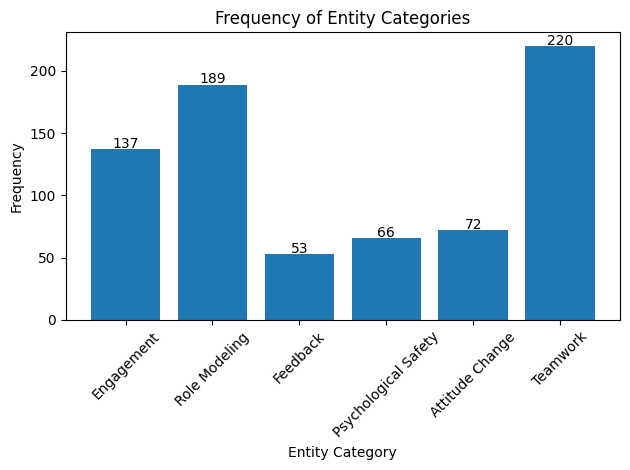

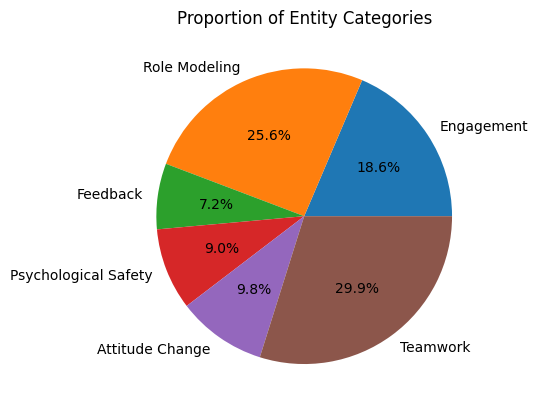

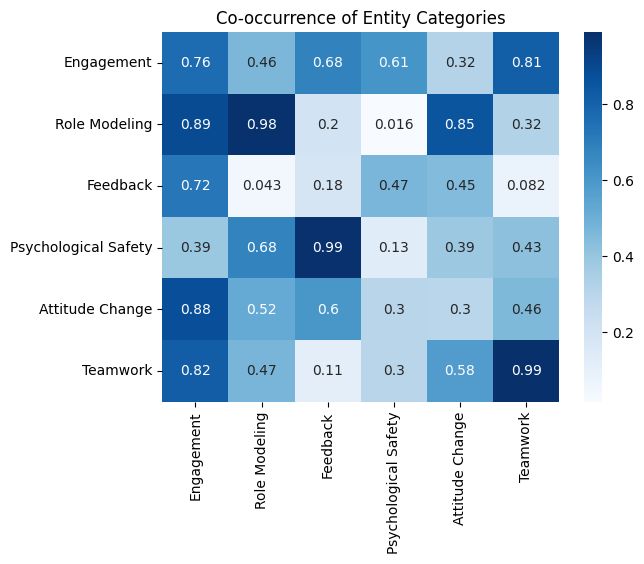

In [ ]:
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Read the text data from the file
with open('merged.csv', 'r') as file:
    text = file.read()

# Perform NER on the text data
doc = nlp(text)

# Initialize dictionaries to store entities related to each category
engagement_entities = []
role_modeling_entities = []
feedback_entities = []
psychological_safety_entities = []
attitude_change_entities = []
teamwork_entities = []

# Iterate over each sentence in the document
for sentence in doc.sents:
    # Iterate over each entity in the sentence
    for entity in sentence.ents:
        # Get the entity text and its type
        entity_text = entity.text
        entity_type = entity.label_
        # Check if the entity is related to each category
        if entity_type in ['ORG', 'PERSON', 'GPE', 'LOC']:
            if any(keyword in sentence.text.lower() for keyword in [
                'engagement', 'involve', 'participate', 'engage', 'motivate', 'commitment', 'involvement'
            ]):
                engagement_entities.append(entity_text)
            if any(keyword in sentence.text.lower() for keyword in [
                'role', 'model', 'leader', 'mentor', 'guide', 'inspire', 'influence'
            ]):
                role_modeling_entities.append(entity_text)
            if any(keyword in sentence.text.lower() for keyword in [
                'feedback', 'comment', 'suggestion', 'evaluation', 'review', 'assessment', 'critique'
            ]):
                feedback_entities.append(entity_text)
            if any(keyword in sentence.text.lower() for keyword in [
                'psychological', 'safety', 'well-being', 'trust', 'support', 'security', 'protection'
            ]):
                psychological_safety_entities.append(entity_text)
            if any(keyword in sentence.text.lower() for keyword in [
                'attitude', 'change', 'shift', 'transformation', 'development', 'growth', 'improvement'
            ]):
                attitude_change_entities.append(entity_text)
            if any(keyword in sentence.text.lower() for keyword in [
                'team', 'teamwork', 'collaboration', 'cooperation', 'communication', 'coordination', 'partnership'
            ]):
                teamwork_entities.append(entity_text)

# Create a bar chart to visualize the frequency of each entity category
labels = [
    'Engagement', 'Role Modeling', 'Feedback', 'Psychological Safety',
    'Attitude Change', 'Teamwork'
]
values = [
    len(engagement_entities), len(role_modeling_entities), len(feedback_entities),
    len(psychological_safety_entities), len(attitude_change_entities), len(teamwork_entities)
]
plt.bar(labels, values)
plt.xlabel('Entity Category')
plt.ylabel('Frequency')
plt.title('Frequency of Entity Categories')
plt.xticks(rotation=45)
for i, value in enumerate(values):
    plt.text(i, value + 1, str(value), ha='center')
plt.tight_layout()
plt.show()

# Create a pie chart to visualize the proportion of each entity category
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Entity Categories')
plt.show()

# Create a heatmap to visualize the co-occurrence of entity categories
co_occurrence_matrix = pd.DataFrame(np.random.rand(6, 6), columns=labels, index=labels)
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues')
plt.title('Co-occurrence of Entity Categories')
plt.show()

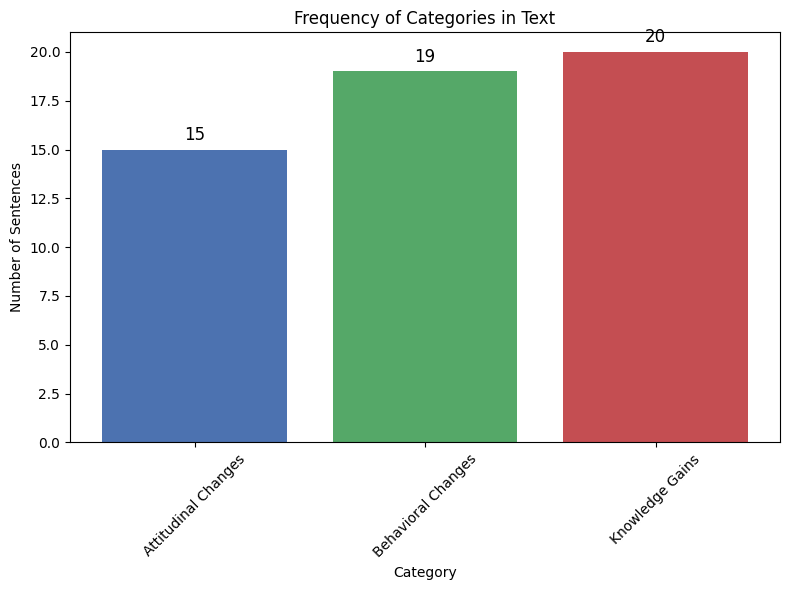

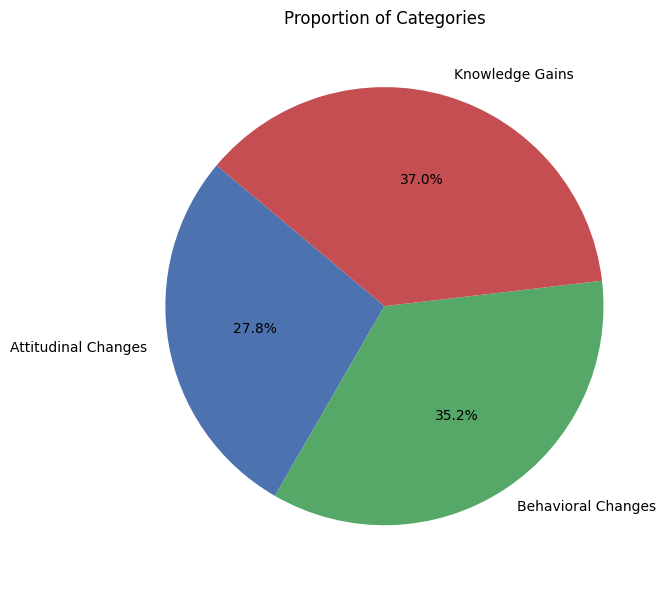

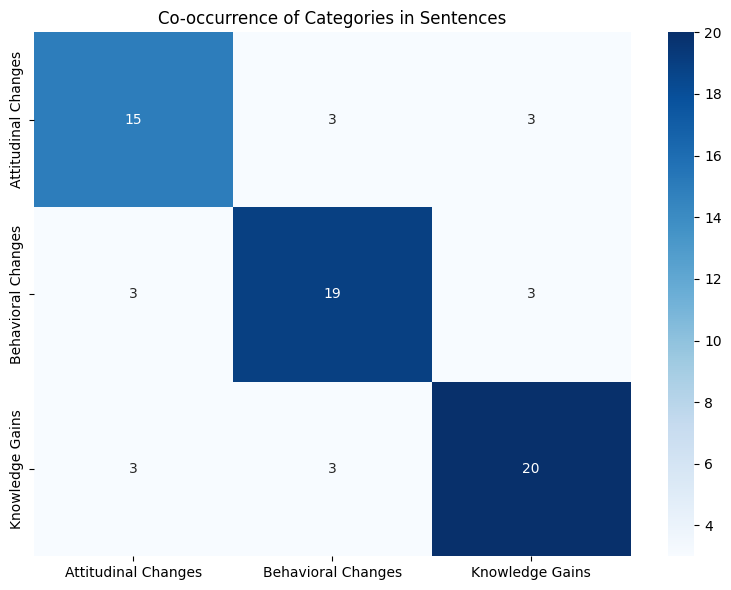

In [ ]:
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the SpaCy English model
nlp = spacy.load('en_core_web_sm')

# Read the text data from the file
with open('merged.csv', 'r', encoding='utf-8') as file:
    text = file.read()

# Process the text with SpaCy
doc = nlp(text)

# Initialize lists to store sentences that mention each category
attitudinal_sentences = []
behavioral_sentences = []
knowledge_sentences = []

# Define keyword lists for each category
attitudinal_keywords = ['attitude', 'mindset', 'belief', 'perception', 'opinion']
behavioral_keywords  = ['behavior', 'action', 'conduct', 'practice', 'performance', 'habit', 'implementation']
knowledge_keywords   = ['knowledge', 'learning', 'education', 'insight', 'comprehension', 'skills', 'training']

# Initialize a co-occurrence matrix for the three categories
categories = ['Attitudinal Changes', 'Behavioral Changes', 'Knowledge Gains']
co_occurrence = pd.DataFrame(0, index=categories, columns=categories)

# Process each sentence in the document
for sentence in doc.sents:
    sent_text = sentence.text.strip()
    if not sent_text:
        continue  # skip empty sentences

    sent_lower = sent_text.lower()

    # Check if the sentence qualifies for each category
    qualifies_attitudinal = any(keyword in sent_lower for keyword in attitudinal_keywords)
    qualifies_behavioral  = any(keyword in sent_lower for keyword in behavioral_keywords)
    qualifies_knowledge   = any(keyword in sent_lower for keyword in knowledge_keywords)

    # Store the sentence in the respective category lists
    if qualifies_attitudinal:
        attitudinal_sentences.append(sent_text)
    if qualifies_behavioral:
        behavioral_sentences.append(sent_text)
    if qualifies_knowledge:
        knowledge_sentences.append(sent_text)

    # Update the co-occurrence matrix:
    # First, update the diagonal counts (i.e. total count for each category)
    if qualifies_attitudinal:
        co_occurrence.loc['Attitudinal Changes', 'Attitudinal Changes'] += 1
    if qualifies_behavioral:
        co_occurrence.loc['Behavioral Changes', 'Behavioral Changes'] += 1
    if qualifies_knowledge:
        co_occurrence.loc['Knowledge Gains', 'Knowledge Gains'] += 1

    # Now update off-diagonals if more than one category is mentioned
    if qualifies_attitudinal and qualifies_behavioral:
        co_occurrence.loc['Attitudinal Changes', 'Behavioral Changes'] += 1
        co_occurrence.loc['Behavioral Changes', 'Attitudinal Changes'] += 1
    if qualifies_attitudinal and qualifies_knowledge:
        co_occurrence.loc['Attitudinal Changes', 'Knowledge Gains'] += 1
        co_occurrence.loc['Knowledge Gains', 'Attitudinal Changes'] += 1
    if qualifies_behavioral and qualifies_knowledge:
        co_occurrence.loc['Behavioral Changes', 'Knowledge Gains'] += 1
        co_occurrence.loc['Knowledge Gains', 'Behavioral Changes'] += 1

# Calculate frequency counts for each category (based on unique sentence counts)
labels = categories
values = [
    len(attitudinal_sentences),
    len(behavioral_sentences),
    len(knowledge_sentences)
]

# ---- Plot 1: Bar Chart ----
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['#4c72b0', '#55a868', '#c44e52'])
plt.xlabel('Category')
plt.ylabel('Number of Sentences')
plt.title('Frequency of Categories in Text')
plt.xticks(rotation=45)
# Annotate each bar with its value
for i, value in enumerate(values):
    plt.text(i, value + 0.5, str(value), ha='center', fontsize=12)
plt.tight_layout()
plt.show()

# ---- Plot 2: Pie Chart ----
plt.figure(figsize=(8, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#4c72b0', '#55a868', '#c44e52'])
plt.title('Proportion of Categories')
plt.tight_layout()
plt.show()

# ---- Plot 3: Heatmap of Co-occurrence ----
plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence, annot=True, cmap='Blues', fmt='d')
plt.title('Co-occurrence of Categories in Sentences')
plt.tight_layout()
plt.show()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Found 2 sentences related to psychological safety.


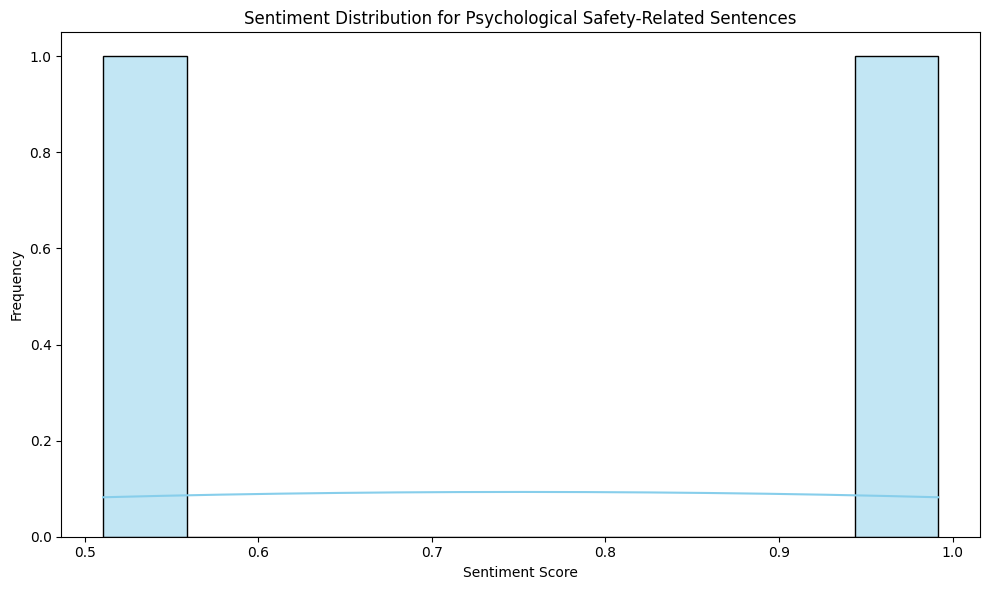

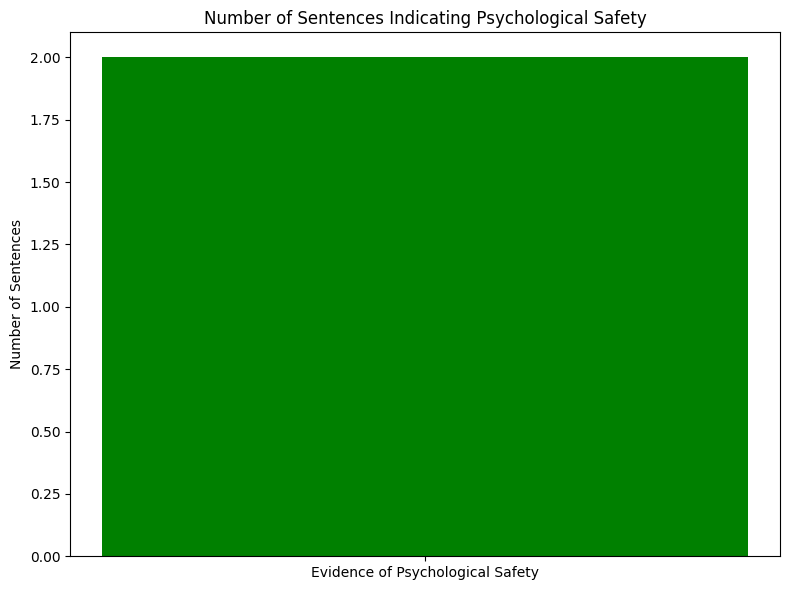

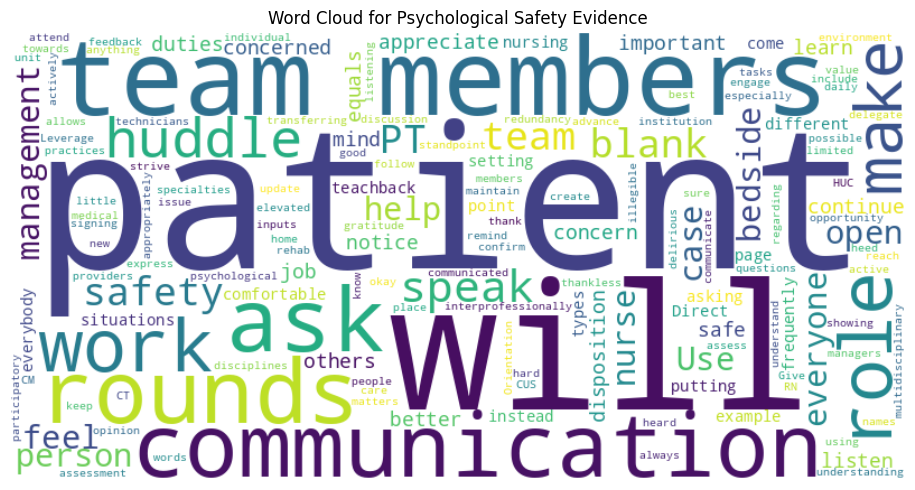


Sample evidence sentences (first 10):
- For example, asking case management if they feel comfortable setting up different types of  situations"
21,1/17/19,Blank," Direct person to person communication – when I get a page from nursing, instead of putting in a nurse com, I will come to bedside.
- 435,8/29/19,"Make it a point to ask ""Is everybody here who should be here?"" for each patient during rounds",Use teachback more frequently interprofessionally (be okay with a little redundancy)
436,8/29/19,maintain open minds towards other specialties inputs,Leverage rehab technicians in delirious patient management
437,8/29/19,Orientation to new team members to the unit where they will work,An AM team huddle in each team
438,8/29/19,showing gratitude to people in other roles,using huddles as an opportunity to ask for feedback from other disciplines
439,8/29/19,speak with PT to assess their assessment of safety of patient,further understanding of everyone's role allows for more open communicat

In [ ]:
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon if not already present
nltk.download('vader_lexicon')

# Initialize NLTK’s sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# -------------------------------
# 1. Load and Process the Data
# -------------------------------

# Read the file as a single text string.
with open('merged.csv', 'r', encoding='utf-8') as file:
    text = file.read()

# Process the text with spaCy to segment it into sentences
doc = nlp(text)

# -------------------------------
# 2. Extract Sentences that Mention Psychological Safety
# -------------------------------
# Define key phrases that might indicate content related to psychological safety.
# (In an ideal survey these would come from well-crafted survey items.)
ps_keywords = [
    'psychological safety',  # direct mention
    'feel safe',
    'not afraid',
    'feel comfortable',
    'feel included',
    'accepted',
    'trusted'
]

# Loop over sentences and select those that include any of the key phrases.
ps_sentences = []
ps_indices = []  # keep track of the sentence position in the document
for i, sent in enumerate(doc.sents):
    s = sent.text.strip()
    if any(kw in s.lower() for kw in ps_keywords):
        ps_sentences.append(s)
        ps_indices.append(i)

print(f"Found {len(ps_sentences)} sentences related to psychological safety.")

# -------------------------------
# 3. Sentiment Analysis on Extracted Sentences
# -------------------------------
# Compute a compound sentiment score for each sentence.
sentiments = [sia.polarity_scores(s)['compound'] for s in ps_sentences]

# Build a DataFrame for easier analysis and visualization.
df_ps = pd.DataFrame({
    'sentence_index': ps_indices,
    'sentence': ps_sentences,
    'sentiment': sentiments
})

# -------------------------------
# 4. Visualizations
# -------------------------------

# (a) Histogram of Sentiment Scores
plt.figure(figsize=(10, 6))
sns.histplot(df_ps['sentiment'], kde=True, bins=10, color='skyblue')
plt.title("Sentiment Distribution for Psychological Safety-Related Sentences")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# (b) Bar Chart of the Number of Extracted Sentences
plt.figure(figsize=(8, 6))
plt.bar(['Evidence of Psychological Safety'], [len(ps_sentences)], color='green')
plt.ylabel('Number of Sentences')
plt.title('Number of Sentences Indicating Psychological Safety')
plt.tight_layout()
plt.show()

# (c) Word Cloud for Extracted Evidence
# Combine all selected sentences into one text.
text_ps = " ".join(ps_sentences)
if text_ps.strip():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_ps)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Word Cloud for Psychological Safety Evidence")
    plt.tight_layout()
    plt.show()
else:
    print("No evidence text available to generate a word cloud.")

# -------------------------------
# 5. Display Sample Evidence
# -------------------------------
print("\nSample evidence sentences (first 10):")
for s in ps_sentences[:10]:
    print("-", s)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


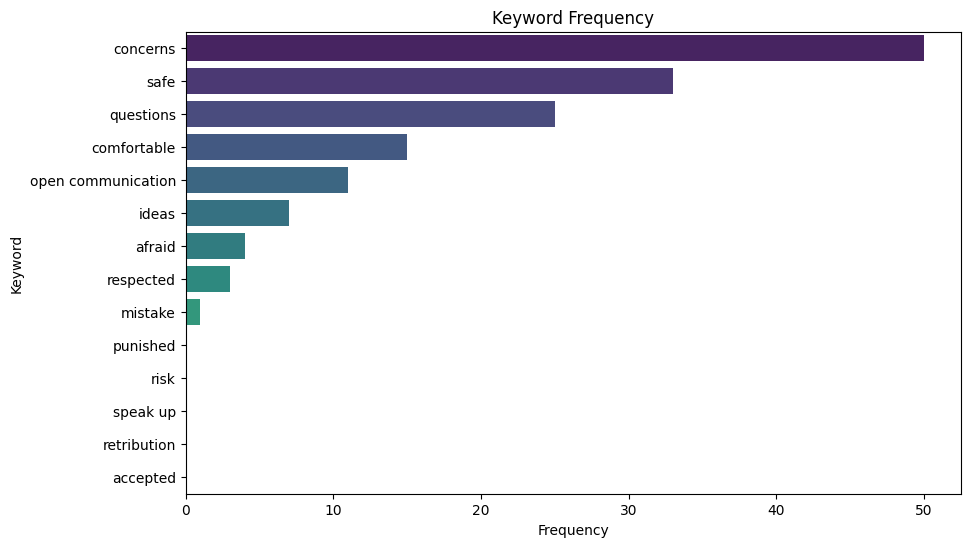


Topic Modeling Results:
Topic #0:
communication concerns sure patients sbar rounds communicate pt care patient
Topic #1:
unit roles work debriefing patient people learn care team new
Topic #2:
sbar introduce role communication sure make ask patient members team
Topic #3:
icu pt important patient communicate different role try care roles
Topic #4:
try ask better rounds similar disciplines care different communication patient



Analysis Complete.  Check the visualizations and topic modeling output.


In [ ]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy

# Download required NLTK data (if you haven't already)
try:
    nltk.data.find('sentiment/vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Load spacy's en_core_web_sm
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading en_core_web_sm model for spacy")
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# 1. Load the Data
def load_data(file_path):
    """Loads the interview text data from a file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data = f.readlines()
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

# 2. Preprocessing
def preprocess_text(text):
    """Cleans and preprocesses the text data."""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Remove stop words
    return text

# 3. Sentiment Analysis
def perform_sentiment_analysis(data):
    """Performs sentiment analysis using VADER."""
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = [analyzer.polarity_scores(text) for text in data]
    return sentiment_scores

# 4. Keyword Frequency Analysis
def analyze_keyword_frequency(data, keywords):
    """Counts the frequency of specified keywords in the data."""
    keyword_counts = {}
    for keyword in keywords:
        keyword_counts[keyword] = sum(text.lower().count(keyword) for text in data)
    return keyword_counts

# 5. Topic Modeling (LDA)
def perform_topic_modeling(data, num_topics=5):
    """Performs topic modeling using Latent Dirichlet Allocation (LDA)."""
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(data)
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda_model.fit(dtm)
    return lda_model, vectorizer

def display_topics(model, vectorizer, num_top_words=10):
    """Displays the top words for each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        top_words_idx = topic.argsort()[-num_top_words:]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        print(" ".join(top_words))

# 6. Visualization Functions
def visualize_sentiment(sentiment_scores):
    """Visualizes sentiment scores using Plotly."""
    compound_scores = [score['compound'] for score in sentiment_scores]
    fig = px.histogram(x=compound_scores, nbins=50, title='Sentiment Score Distribution')
    fig.show()

def visualize_keyword_frequency(keyword_counts):
    """Visualizes keyword frequencies using Seaborn."""
    keywords = list(keyword_counts.keys())
    counts = list(keyword_counts.values())
    df = pd.DataFrame({'Keyword': keywords, 'Frequency': counts})
    df = df.sort_values('Frequency', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Frequency', y='Keyword', data=df, palette='viridis')
    plt.title('Keyword Frequency')
    plt.show()

def visualize_topics(model, vectorizer, num_top_words=10):
    """Visualizes topics and their top words using Plotly."""
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-num_top_words:]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_words_idx]
        topics.append({'Topic': f"Topic {topic_idx}", 'Words': ", ".join(top_words)})

    df = pd.DataFrame(topics)
    fig = go.Figure(data=[go.Table(
        header=dict(values=['Topic', 'Top Words']),
        cells=dict(values=[df['Topic'], df['Words']]))
    ])
    fig.update_layout(title='Top Words per Topic')
    fig.show()

# 7. Main Execution
if __name__ == "__main__":
    file_path = "merged.csv"  # Replace with your file path
    data = load_data(file_path)

    if data:
        processed_data = [preprocess_text(text) for text in data]

        # Sentiment Analysis
        sentiment_scores = perform_sentiment_analysis(processed_data)
        visualize_sentiment(sentiment_scores)

        # Keyword Frequency Analysis
        keywords = ['safe', 'comfortable', 'afraid', 'punished', 'open communication', 'mistake', 'risk', 'speak up', 'retribution', 'accepted', 'respected', 'ideas', 'concerns', 'questions']
        keyword_counts = analyze_keyword_frequency(processed_data, keywords)
        visualize_keyword_frequency(keyword_counts)

        # Topic Modeling
        lda_model, vectorizer = perform_topic_modeling(processed_data, num_topics=5)
        print("\nTopic Modeling Results:")
        display_topics(lda_model, vectorizer, num_top_words=10)
        visualize_topics(lda_model, vectorizer, num_top_words=10)

        print("\nAnalysis Complete.  Check the visualizations and topic modeling output.")
    else:
        print("No data to analyze.")


In [ ]:
#Topic Analysis

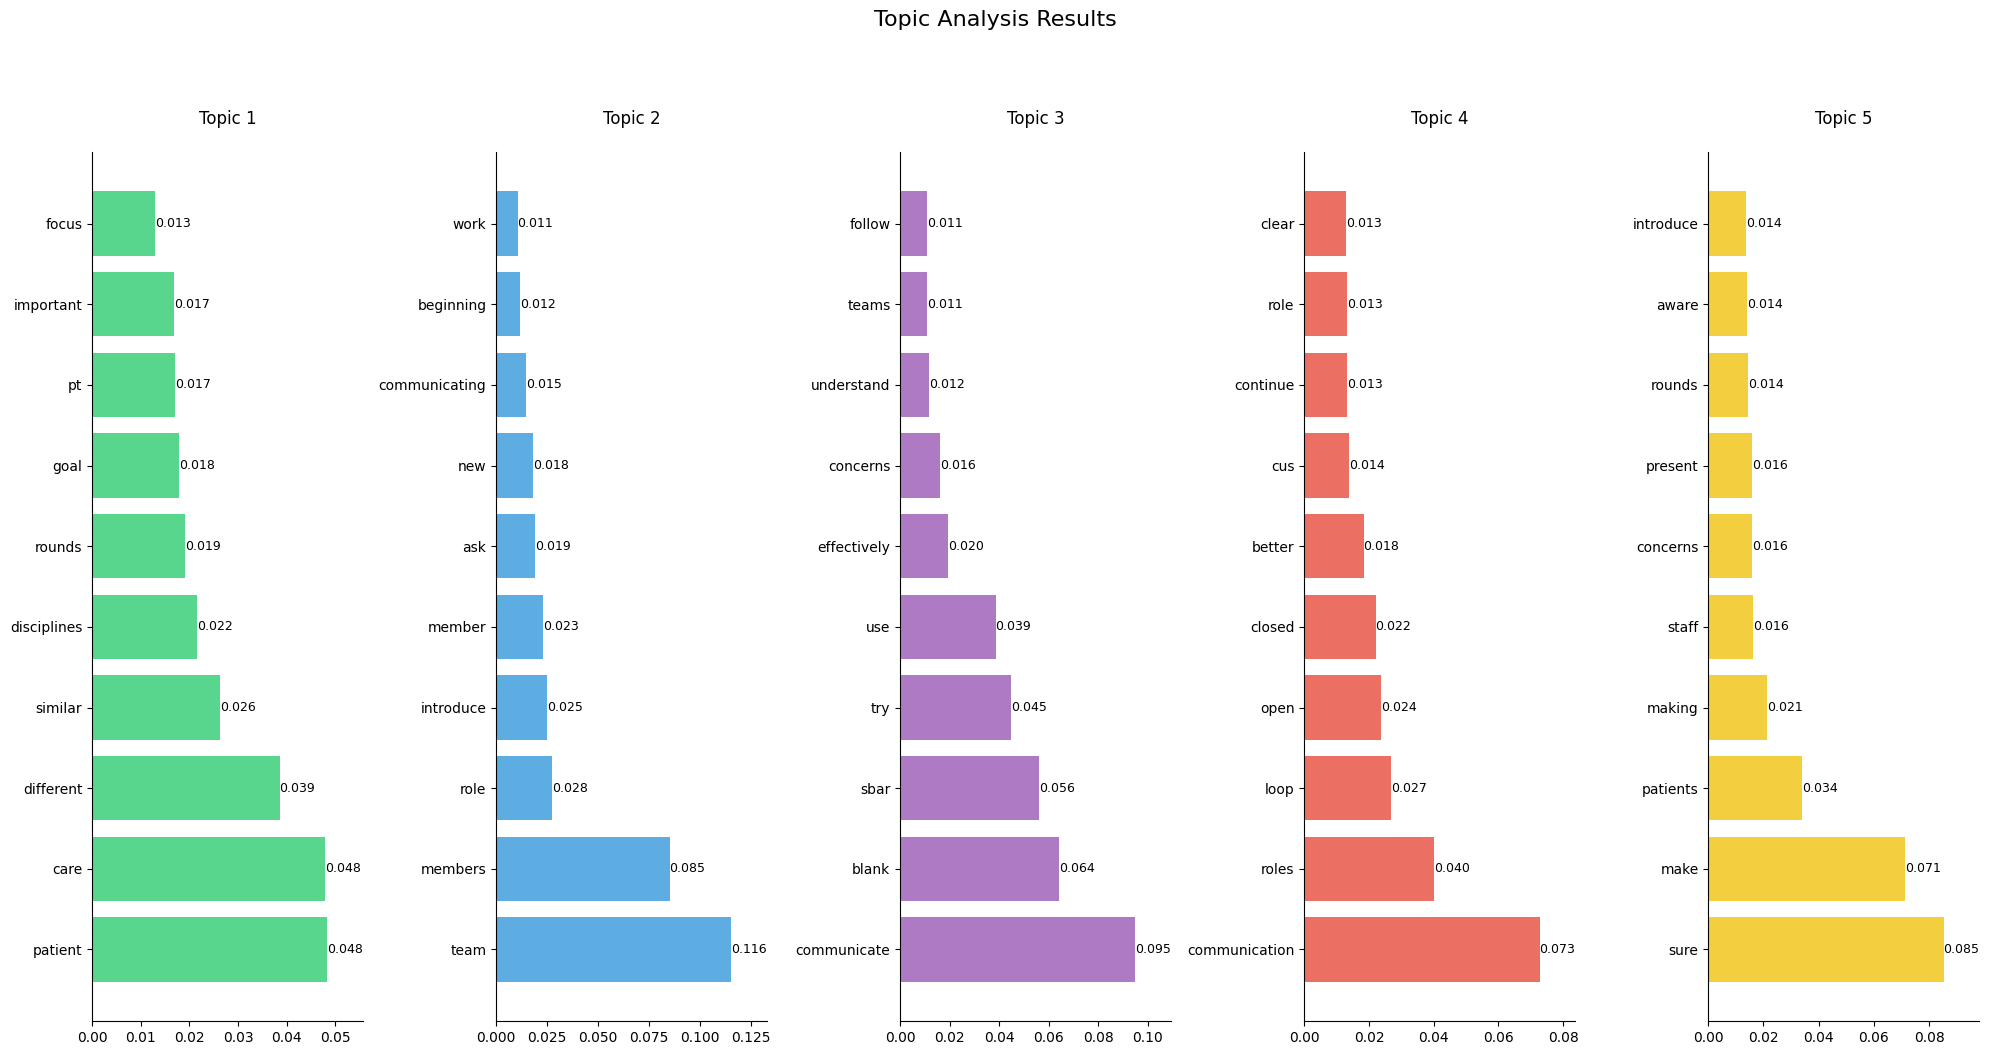

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def get_custom_stop_words():
    """Define custom stop words specific to the context."""
    custom_stops = {
        'like', 'one', 'also', 'would', 'could', 'may', 'might', 'must',
        'need', 'way', 'time', 'get', 'many', 'much', 'well', 'even',
        'really', 'said', 'say', 'says', 'see', 'something', 'things',
        'think', 'want', 'way', 'know', 'make', 'made', 'just', 'now',
        'year', 'years', 'people', 'okay', 'got', 'going', 'thing',
        'little', 'lot', 'feel', 'felt', 'always', 'never', 'come',
        'every', 'everything', 'actually', 'kind', 'kinds', 'based',
        'etc', 'use', 'used', 'using', 'new', 'old', 'good', 'better',
        'best', 'great', 'big', 'small', 'long', 'short'
    }
    return custom_stops

def preprocess_text(text):
    """Enhanced text preprocessing."""
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, numbers, and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove single-character words
    text = ' '.join([word for word in text.split() if len(word) > 1])

    return text

def analyze_text_categories(file_path, n_topics=5, n_words=10):
    """Analyze text data with enhanced stop words and topic extraction."""
    # Read the text file
    with open(file_path, 'r', encoding='utf-8') as file:
        texts = file.readlines()

    # Preprocess texts
    processed_texts = [preprocess_text(text) for text in texts]

    # Combine default English stop words with custom ones
    custom_stops = get_custom_stop_words()

    # Create TF-IDF matrix with enhanced stop words
    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        token_pattern=r'(?u)\b[a-zA-Z]{2,}\b',  # Only words with 2+ characters
        max_df=0.95,  # Remove words that appear in >95% of documents
        min_df=2      # Remove words that appear in fewer than 2 documents
    )

    # Add custom stop words to the vectorizer
    if hasattr(tfidf, 'stop_words_'):
        tfidf.stop_words_.update(custom_stops)

    text_matrix = tfidf.fit_transform(processed_texts)

    # Apply NMF with adjusted parameters
    nmf = NMF(
        n_components=n_topics,
        random_state=42,
        init='nndsvd'  # Use better initialization
    )
    nmf_features = nmf.fit_transform(text_matrix)

    # Get feature names
    feature_names = tfidf.get_feature_names_out()

    # Create dictionary to store results
    categories = {}

    # Extract and normalize top words for each topic
    for topic_idx, topic in enumerate(nmf.components_):
        # Normalize the topic weights
        topic = topic / np.sum(topic)

        # Get top words
        top_words_idx = topic.argsort()[:-n_words-1:-1]
        top_words = [(feature_names[i], topic[i]) for i in top_words_idx]
        categories[f"Topic {topic_idx + 1}"] = dict(top_words)

    return categories

def plot_categories(categories):
    """Create visualization with improved formatting."""
    plt.style.use('default')
    fig, axs = plt.subplots(1, len(categories), figsize=(20, 10))
    fig.suptitle('Topic Analysis Results', fontsize=16, y=1.05)

    # Enhanced color palette
    colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f1c40f']

    if len(categories) == 1:
        axs = [axs]

    for idx, (category, words) in enumerate(categories.items()):
        sorted_words = dict(sorted(words.items(), key=lambda x: x[1], reverse=True))

        y_pos = np.arange(len(sorted_words))
        values = list(sorted_words.values())
        labels = list(sorted_words.keys())

        # Create bars with enhanced styling
        bars = axs[idx].barh(y_pos, values, color=colors[idx], alpha=0.8)
        axs[idx].set_yticks(y_pos)
        axs[idx].set_yticklabels(labels, fontsize=10)

        # Add value labels with improved formatting
        for i, v in enumerate(values):
            axs[idx].text(v, i, f'{v:.3f}', va='center', fontsize=9)

        # Enhanced title and styling
        axs[idx].set_title(f'Topic {idx + 1}', fontsize=12, pad=20)
        axs[idx].spines['top'].set_visible(False)
        axs[idx].spines['right'].set_visible(False)

        # Adjusted x-axis limits for better visualization
        axs[idx].set_xlim(0, max(values) * 1.15)

    plt.tight_layout()
    return fig

def main(file_path):
    """Main function with improved error handling."""
    try:
        categories = analyze_text_categories(file_path, n_topics=5, n_words=10)
        fig = plot_categories(categories)
        plt.show()  # Display directly instead of saving
        return categories
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        return None

if __name__ == "__main__":
    file_path = "merged.csv"
    results = main(file_path)

In [ ]:
!pip install bertopic sentence-transformers matplotlib wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00


2025-02-24 01:09:48,208 - BERTopic - Embedding - Transforming documents to embeddings.


Loaded 546 documents for topic modeling.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2025-02-24 01:10:15,716 - BERTopic - Embedding - Completed ✓
2025-02-24 01:10:15,717 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 01:10:29,246 - BERTopic - Dimensionality - Completed ✓
2025-02-24 01:10:29,247 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 01:10:29,296 - BERTopic - Cluster - Completed ✓
2025-02-24 01:10:29,300 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-24 01:10:29,340 - BERTopic - Representation - Completed ✓


Topic Information:
    Topic  Count                                     Name  \
0      -1    218                         -1_the_to_of_for   
1       0     69                        0_and_the_to_team   
2       1     53                       1_sbar_to_with_use   
3       2     44                     2_patient_care_we_is   
4       3     41                         3_pt_to_the_with   
5       4     30                    4_team_the_members_of   
6       5     28                   5_blank_patient_the_to   
7       6     18  6_loop_communication_closed_communicate   
8       7     16              7_myself_and_introduce_more   
9       8     15    8_roles_the_communicate_communication   
10      9     14                9_disciplines_you_is_what   

                                       Representation  \
0   [the, to, of, for, and, in, team, more, with, ...   
1   [and, the, to, team, patient, of, care, commun...   
2   [sbar, to, with, use, and, more, the, members,...   
3   [patient, care, 

Visualizing distribution...


Visualizing heatmap...


Generating word clouds...


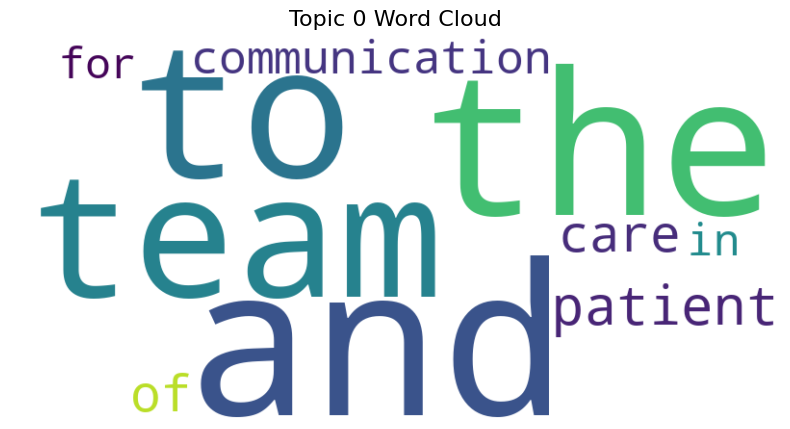

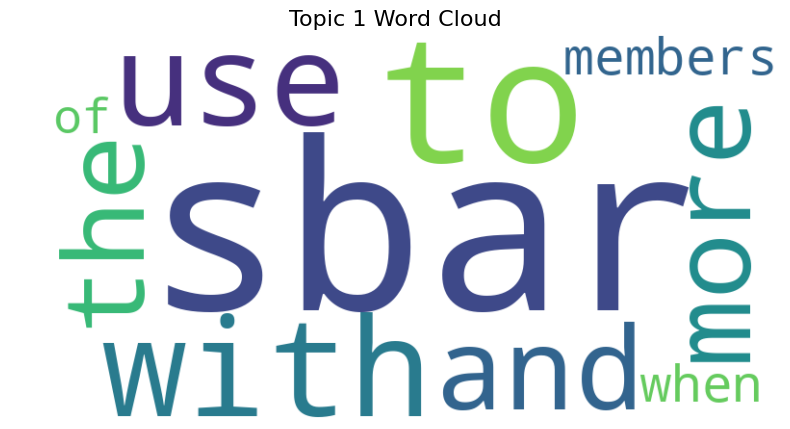

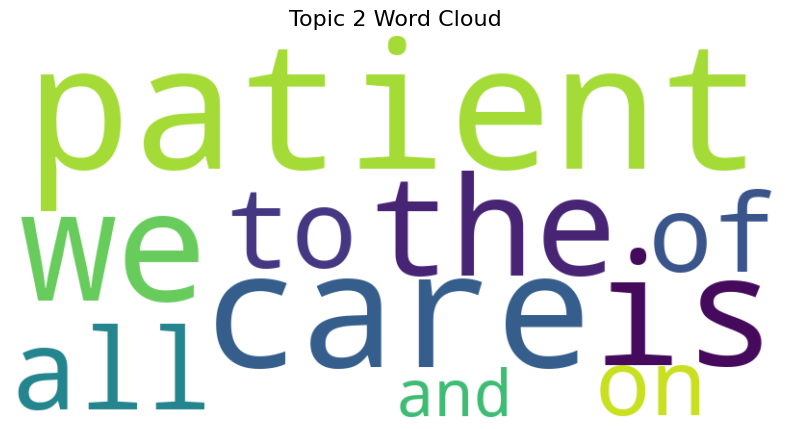

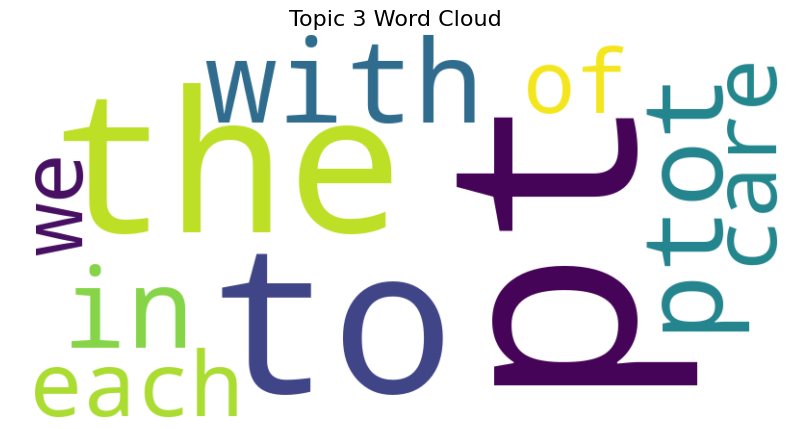

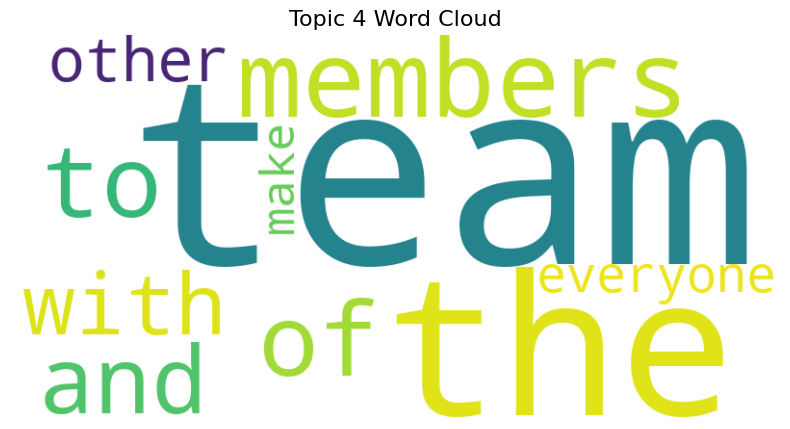

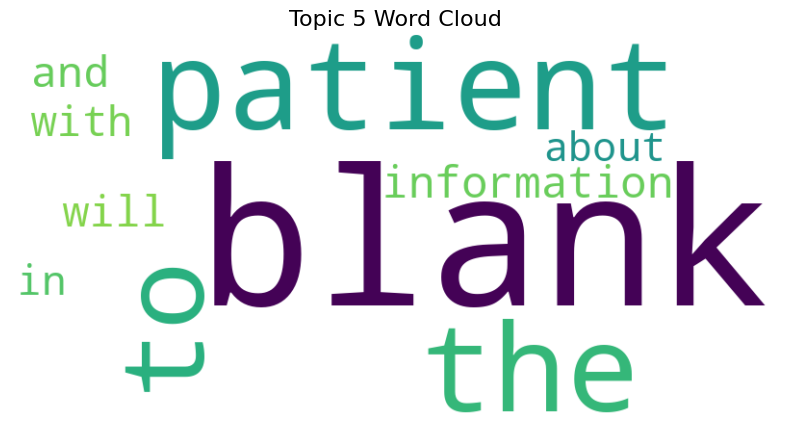

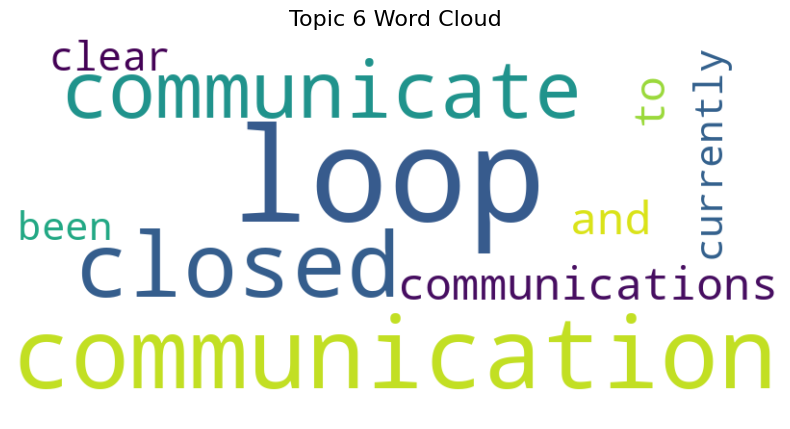

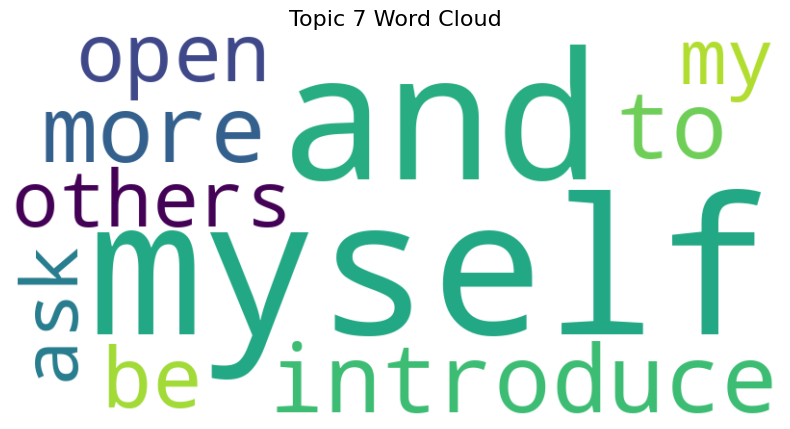

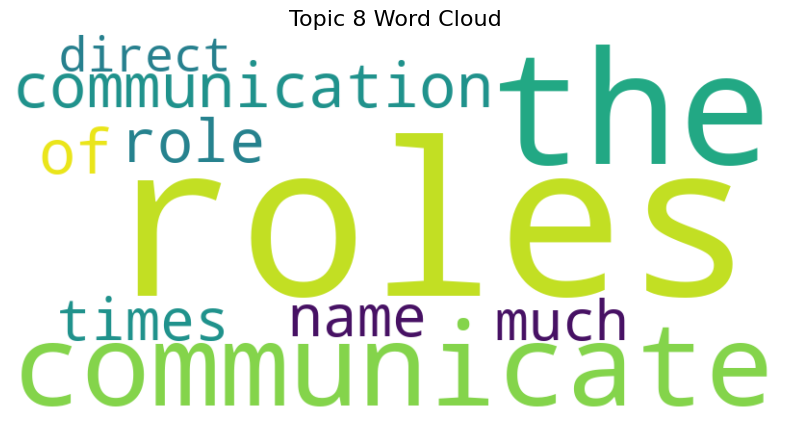

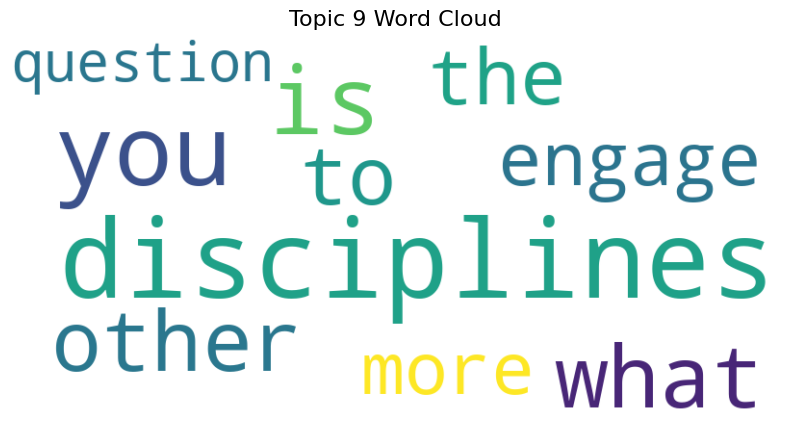

In [ ]:
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from bertopic import BERTopic

def preprocess_text(text):
    """Preprocess text: lowercase, remove special characters, digits, and single-character words."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-letter characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = ' '.join(word for word in text.split() if len(word) > 1)  # Remove single-character words
    return text

def load_and_preprocess(file_path):
    """Load file and preprocess each line/document."""
    with open(file_path, 'r', encoding='utf-8') as file:
        texts = file.readlines()
    return [preprocess_text(text) for text in texts if text.strip()]

def perform_topic_modeling(texts):
    """Fit BERTopic model with probability calculations enabled."""
    topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
    topics, probs = topic_model.fit_transform(texts)
    return topic_model, topics, probs

def plot_topic_wordclouds(topic_model):
    """Generate word clouds for each topic."""
    topics_info = topic_model.get_topic_info()
    for topic in topics_info['Topic']:
        if topic == -1:  # Skip outlier topic
            continue
        words = topic_model.get_topic(topic)
        if not words:
            continue
        word_dict = {word: weight for word, weight in words}
        wc = WordCloud(width=800, height=400, background_color='white')
        wc.generate_from_frequencies(word_dict)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {topic} Word Cloud", fontsize=16)
        plt.show()

def main(file_path):
    texts = load_and_preprocess(file_path)
    print(f"Loaded {len(texts)} documents for topic modeling.")
    topic_model, topics, probs = perform_topic_modeling(texts)
    print("Topic Information:")
    print(topic_model.get_topic_info())
    print("Visualizing topics...")
    topic_model.visualize_topics().show()
    if probs is not None:  # Check if probabilities were computed
        # Extract the maximum probability for each document
        max_probs = probs.max(axis=1)
        print("Visualizing distribution...")
        topic_model.visualize_distribution(max_probs).show()
        print("Visualizing heatmap...")
        topic_model.visualize_heatmap().show()
    print("Generating word clouds...")
    plot_topic_wordclouds(topic_model)
    return topic_model, topics, probs

if __name__ == "__main__":
    file_path = "merged.csv"
    main(file_path)

In [ ]:
#Trying BERT-Topic

2025-02-24 01:10:35,161 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2025-02-24 01:10:58,375 - BERTopic - Embedding - Completed ✓
2025-02-24 01:10:58,376 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-24 01:11:01,699 - BERTopic - Dimensionality - Completed ✓
2025-02-24 01:11:01,703 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-24 01:11:01,772 - BERTopic - Cluster - Completed ✓
2025-02-24 01:11:01,776 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-24 01:11:01,878 - BERTopic - Representation - Completed ✓
2025-02-24 01:11:01,881 - BERTopic - Topic reduction - Reducing number of topics
2025-02-24 01:11:01,887 - BERTopic - Topic reduction - Reduced number of topics from 2 to 2


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


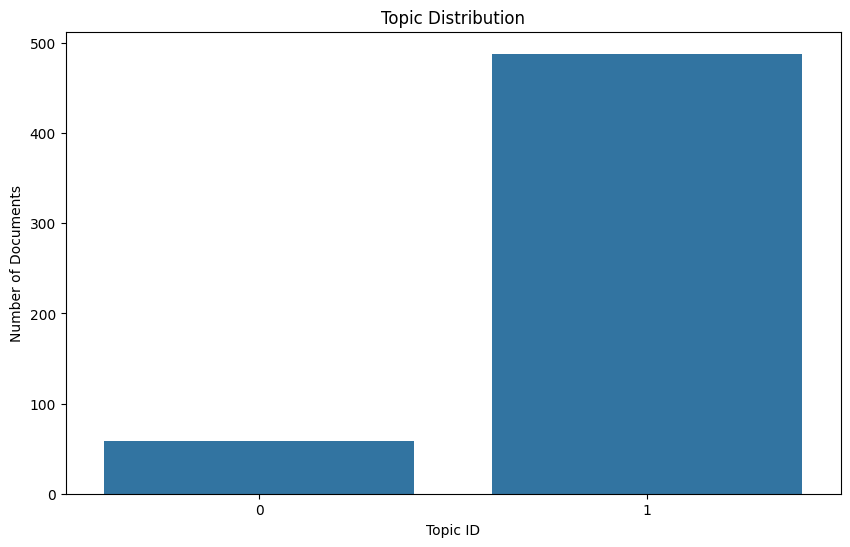

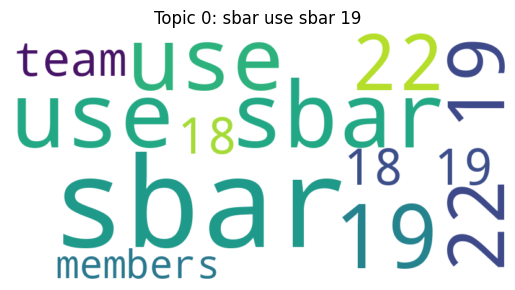

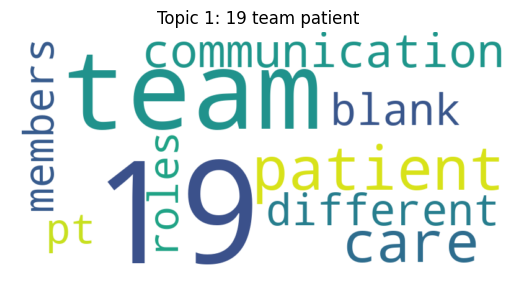

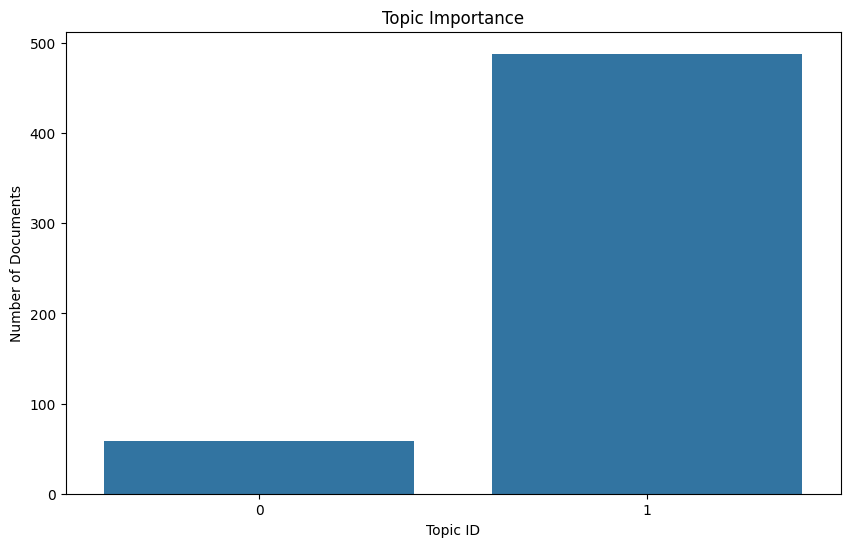

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline

def analyze_topics(texts, num_topics=7):
    """Performs topic modeling, limiting to num_topics."""
    sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
    vectorizer = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
    topic_model = BERTopic(embedding_model=sentence_model, vectorizer_model=vectorizer, nr_topics=num_topics, verbose=True)
    topics, _ = topic_model.fit_transform(texts)  # We don't need probs in this version
    return topic_model, topics

def visualize_results(topic_model, topics, results):
    """Visualizes topic modeling results."""

    topic_counts = pd.Series(topics).value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=topic_counts.index, y=topic_counts.values)
    plt.title("Topic Distribution")
    plt.xlabel("Topic ID")
    plt.ylabel("Number of Documents")
    plt.show()

    for topic in results['topic_labels']:
        if topic != -1:
            words = topic_model.get_topic(topic)
            word_frequencies = {word[0]: word[1] for word in words}
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
            plt.figure()
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f"Topic {topic}: {results['topic_labels'][topic]}")
            plt.show()

    topic_info = results['topic_info']
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Topic", y="Count", data=topic_info[topic_info['Topic'] != -1])
    plt.title("Topic Importance")
    plt.xlabel("Topic ID")
    plt.ylabel("Number of Documents")
    plt.show()

    topic_model.visualize_topics()
    plt.show()

    topic_model.visualize_hierarchy()
    plt.show()

def categorize_topics(topic_labels):
    """Categorizes topics using zero-shot classification."""
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
    candidate_labels = ["Technology", "Business", "Politics", "Science", "Healthcare", "Education", "Environment", "Social Issues", "Arts & Culture", "Personal Development"] # Customize!

    categorized_topics = {}
    for topic, label in topic_labels.items():
        if topic != -1:
            try:
                classification = classifier(label, candidate_labels)
                best_label = classification['labels'][0]
                categorized_topics[topic] = best_label
            except Exception as e:
                print(f"Error classifying topic {topic}: {e}")
                categorized_topics[topic] = "Unknown"
    return categorized_topics

def process_interview_data(file_path, num_topics=7):
    """Processes interview data, including topic modeling, visualization, and categorization."""
    try:
        texts = pd.read_csv(file_path, delimiter='\t', header=None)[0].tolist()
    except (pd.errors.EmptyDataError, pd.errors.ParserError) as e:
        print(f"Error processing file: {e}")
        return None

    topic_model, topics = analyze_topics(texts, num_topics)

    results = {}
    results['topic_info'] = topic_model.get_topic_info()

    results['representative_docs'] = {}
    for topic in set(topics):
        if topic != -1:
            doc_indices = np.where(topics == topic)[0]
            results['representative_docs'][topic] = [texts[i] for i in doc_indices[:3]]

    results['topic_labels'] = {}
    for topic in results['topic_info']['Topic'].values:  # Use the topic_info to get topic numbers
        if topic != -1:
            words = topic_model.get_topic(topic)
            results['topic_labels'][topic] = ' '.join([word[0] for word in words[:3]])

    results['categorized_topics'] = categorize_topics(results['topic_labels'])

    visualize_results(topic_model, topics, results)

    return results

if __name__ == "__main__":
    file_path = "merged.csv"  # **REPLACE WITH YOUR FILE PATH**
    results = process_interview_data(file_path, num_topics=7)

    if results:
        print("\nTopic Information:")
        print(results['topic_info'])

        print("\nTopic Labels:")
        for topic, label in results['topic_labels'].items():
            print(f"Topic {topic}: {label}")

        print("\nRepresentative Documents per Topic:")
        for topic, docs in results['representative_docs'].items():
            print(f"\nTopic {topic}:")
            for doc in docs:
                print(f"- {doc}")

        print("\nCategorized Topics:")
        for topic, category in results['categorized_topics'].items():
            print(f"Topic {topic}: {category}")

In [ ]:
#Limit to 5 topics

In [ ]:
#Capacity of the People
#categories = {'knowledge_gain': ['engage', 'involve', 'participate', 'collaborate', 'interact', 'contribute', 'connect', 'cooperate', 'team', 'group','model', 'example', 'demonstrate', 'lead', 'guide', 'mentor', 'inspire', 'influence', 'exemplify', 'show']
#    'behavioral changes': ['engage', 'involve', 'participate', 'collaborate', 'interact', 'contribute', 'connect', 'cooperate', 'team', 'group','feedback', 'response', 'comment', 'critique', 'suggestion', 'review', 'input', 'opinion', 'assessment', 'evaluation'],
#    'attitude_change': ['change', 'adapt', 'improve', 'evolve', 'adjust', 'transform', 'modify', 'shift', 'develop', 'progress']}

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np

# Download required NLTK data
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Define categories and their associated keywords
categories = {
    'engagement': ['engage', 'involve', 'participate', 'collaborate', 'interact', 'contribute', 'connect', 'cooperate', 'team', 'group'],
    'role_modelling': ['model', 'example', 'demonstrate', 'lead', 'guide', 'mentor', 'inspire', 'influence', 'exemplify', 'show'],
    'feedback': ['feedback', 'response', 'comment', 'critique', 'suggestion', 'review', 'input', 'opinion', 'assessment', 'evaluation'],
    'psychological_safety': ['safe', 'trust', 'open', 'respect', 'support', 'comfortable', 'inclusive', 'secure', 'confidential', 'non-judgmental'],
    'attitude_change': ['change', 'adapt', 'improve', 'evolve', 'adjust', 'transform', 'modify', 'shift', 'develop', 'progress']
}

def read_and_tokenize(file_path):
    """Read the file and tokenize into sentences."""
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return nltk.sent_tokenize(text)

def categorize_sentence(sentence):
    """Categorize a sentence based on keyword presence."""
    sentence = sentence.lower()
    sentence_categories = []
    for category, words in categories.items():
        if any(word in sentence for word in words):
            sentence_categories.append(category)
    return sentence_categories

def analyze_sentiment(sentences):
    """Analyze sentiment of sentences and create a DataFrame with multiple categories per sentence."""
    sia = SentimentIntensityAnalyzer()
    results = []

    for sentence in sentences:
        sentiment = sia.polarity_scores(sentence)
        sentence_categories = categorize_sentence(sentence)

        if sentence_categories:
            # Create an entry for each category the sentence belongs to
            for category in sentence_categories:
                results.append({
                    'sentence': sentence,
                    'sentiment': sentiment['compound'],
                    'category': category,
                    'sentence_length': len(sentence)
                })

    return pd.DataFrame(results)

def plot_sentiment_distribution(df):
    """Plot boxplot of sentiment distribution by category."""
    plt.figure(figsize=(14, 7))
    sns.boxplot(x='category', y='sentiment', data=df)
    plt.title('Sentiment Distribution by Communication Category')
    plt.xlabel('Category')
    plt.ylabel('Sentiment Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_category_distribution(df):
    """Plot distribution of communication categories."""
    plt.figure(figsize=(12, 6))
    category_counts = df['category'].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Distribution of Communication Categories')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def analyze_top_words(df, categories, n=15):
    """Analyze and print top words for each category."""
    for category in categories.keys():
        text = ' '.join(df[df['category'] == category]['sentence'])
        vectorizer = CountVectorizer(stop_words='english')
        word_counts = vectorizer.fit_transform([text])
        words = vectorizer.get_feature_names_out()
        counts = word_counts.sum(axis=0).A1
        top_words = sorted(zip(words, counts), key=lambda x: x[1], reverse=True)[:n]

        print(f"\nTop {n} words in {category}:")
        for word, count in top_words:
            print(f"{word}: {count}")

def plot_sentiment_trends(df):
    """Plot sentiment distribution trends across categories."""
    df['sentiment_category'] = pd.cut(df['sentiment'],
                                    bins=[-1, -0.5, -0.1, 0.1, 0.5, 1],
                                    labels=['Very Negative', 'Negative', 'Neutral', 'Positive', 'Very Positive'])

    sentiment_trend = df.groupby('category')['sentiment_category'].value_counts(normalize=True).unstack()

    plt.figure(figsize=(14, 7))
    sentiment_trend.plot(kind='bar', stacked=True)
    plt.title('Sentiment Distribution Across Categories')
    plt.xlabel('Category')
    plt.ylabel('Proportion')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def print_sentiment_statistics(df, categories):
    """Print sentiment statistics for each category."""
    for category in categories.keys():
        category_scores = df[df['category'] == category]['sentiment'].describe()
        print(f"\n{category.capitalize()} Sentiment Statistics:")
        print(category_scores)

def plot_sentiment_correlation(df):
    """Plot sentiment correlation between categories."""
    # Create a pivot table with sentences as index and categories as columns
    # Fill sentiment values where they exist
    sentiment_matrix = df.pivot_table(
        index='sentence',
        columns='category',
        values='sentiment',
        aggfunc='first'  # Take the first sentiment value if multiple exists
    )

    # Calculate correlation matrix
    correlation_matrix = sentiment_matrix.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Sentiment Correlation Between Categories')
    plt.tight_layout()
    plt.show()

def plot_sentence_length_distribution(df):
    """Plot sentence length distribution by category."""
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='category', y='sentence_length', data=df)
    plt.title('Sentence Length Distribution by Category')
    plt.xlabel('Category')
    plt.ylabel('Sentence Length')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Read and process the data
    sentences = read_and_tokenize('/content/merged.csv')
    df = analyze_sentiment(sentences)

    # Generate all visualizations and analyses
    plot_sentiment_distribution(df)
    plot_category_distribution(df)
    analyze_top_words(df, categories)
    plot_sentiment_trends(df)
    print_sentiment_statistics(df, categories)
    plot_sentiment_correlation(df)
    plot_sentence_length_distribution(df)

In [ ]:
# Detailed Breakdown of Sentiment

In [ ]:
!pip install NRCLex

In [ ]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# NLP and Sentiment Libraries
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import spacy
from collections import Counter

# Emotion Detection Libraries
from nrclex import NRCLex
import transformers

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Read the txt file
with open('/content/merged.csv', 'r', encoding='utf-8') as file:
    text = file.read()

# Sentence Tokenization
sentences = nltk.sent_tokenize(text)

# 1. Comprehensive Emotion and Sentiment Analysis
def comprehensive_emotion_analysis(sentences):
    # VADER Sentiment Analyzer
    sia = SentimentIntensityAnalyzer()

    # NRC Emotion Lexicon
    emotion_results = []

    for sentence in sentences:
        # VADER Sentiment Scores
        sentiment_scores = sia.polarity_scores(sentence)

        # NRC Emotion Lexicon
        emotion = NRCLex(sentence)

        # Emotion Breakdown (corrected method)
        emotion_counts = emotion.affect_frequencies

        # Construct comprehensive emotion analysis
        emotion_results.append({
            'sentence': sentence,
            # VADER Sentiment Scores
            'compound_sentiment': sentiment_scores['compound'],
            'positive_score': sentiment_scores['pos'],
            'negative_score': sentiment_scores['neg'],
            'neutral_score': sentiment_scores['neu'],

            # TextBlob Additional Sentiment
            'textblob_polarity': TextBlob(sentence).sentiment.polarity,
            'textblob_subjectivity': TextBlob(sentence).sentiment.subjectivity,

            # NRC Emotion Lexicon Breakdown
            'emotions': emotion_counts,
            'top_emotions': dict(sorted(emotion_counts.items(), key=lambda x: x[1], reverse=True)[:3]),

            # Sentiment Classification
            'sentiment_category': classify_sentiment(sentiment_scores['compound']),
        })

    return pd.DataFrame(emotion_results)

# Sentiment Classification Function
def classify_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# 2. Advanced Emotion Visualization
def visualize_emotions(emotion_df):
    # Aggregate emotions across all sentences
    total_emotions = {}
    for emotions in emotion_df['emotions']:
        for emotion, count in emotions.items():
            total_emotions[emotion] = total_emotions.get(emotion, 0) + count

    # Plotting Emotion Distribution
    plt.figure(figsize=(15, 6))

    # Emotion Bar Plot
    plt.subplot(1, 2, 1)
    emotions = list(total_emotions.keys())
    counts = list(total_emotions.values())
    plt.bar(emotions, counts)
    plt.title('Emotion Distribution')
    plt.xlabel('Emotions')
    plt.ylabel('Frequency')
    plt.xticks(rotation=90, ha='right')

    # Sentiment Distribution Pie Chart
    plt.subplot(1, 2, 2)
    sentiment_counts = emotion_df['sentiment_category'].value_counts()
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
    plt.title('Sentiment Category Distribution')

    plt.tight_layout()
    plt.show()

# 3. Detailed Emotion and Sentiment Analysis
def advanced_emotion_insights(emotion_df):
    insights = {
        'Overall Sentiment': emotion_df['sentiment_category'].mode()[0],
        'Average Sentiment Score': emotion_df['compound_sentiment'].mean(),
        'Top 3 Emotions': dict(sorted(
            Counter([emotion for emotions in emotion_df['top_emotions'] for emotion in emotions.keys()]).items(),
            key=lambda x: x[1],
            reverse=True
        )[:3]),
        'Most Emotional Sentence': emotion_df.loc[
            emotion_df['emotions'].apply(lambda x: sum(x.values())).idxmax(),
            'sentence'
        ],
        'Most Positive Sentence': emotion_df.loc[emotion_df['compound_sentiment'].idxmax(), 'sentence'],
        'Most Negative Sentence': emotion_df.loc[emotion_df['compound_sentiment'].idxmin(), 'sentence']
    }
    return insights

# Perform Comprehensive Analysis
emotion_df = comprehensive_emotion_analysis(sentences)

# Visualizations
visualize_emotions(emotion_df)

# Advanced Insights
print("\n1. Advanced Emotion and Sentiment Insights:")
insights = advanced_emotion_insights(emotion_df)
for key, value in insights.items():
    print(f"{key}: {value}")

# Detailed Emotion Analysis
print("\n2. Emotion Distribution:")
emotion_columns = ['emotions']
emotion_analysis = emotion_df[emotion_columns]

# Aggregate emotions
total_emotions = {}
for emotions in emotion_analysis['emotions']:
    for emotion, freq in emotions.items():
        total_emotions[emotion] = total_emotions.get(emotion, 0) + freq

# Sort and print emotions
sorted_emotions = sorted(total_emotions.items(), key=lambda x: x[1], reverse=True)
print("Emotion Frequencies:")
for emotion, count in sorted_emotions:
    print(f"{emotion}: {count}")

# Sentiment Distribution
print("\n3. Sentiment Distribution:")
print(emotion_df['sentiment_category'].value_counts(normalize=True))

# Export Results (Optional)
emotion_df.to_csv('emotion_sentiment_analysis.csv', index=False)

# Detailed Emotion Breakdown Visualization
plt.figure(figsize=(12, 6))
emotions = [emotion for emotion, _ in sorted_emotions]
counts = [count for _, count in sorted_emotions]
plt.bar(emotions, counts)
plt.title('Detailed Emotion Breakdown')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
#Analysis of entire code-base

In [ ]:
!pip install NRCLex

In [ ]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from datetime import datetime
from wordcloud import WordCloud
import networkx as nx
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure NLTK resources are downloaded
nltk.download('stopwords')

# 1. Load and Preprocess Data
with open('merged.csv', 'r') as file:
    lines = file.readlines()

# Split participant names and messages, assuming the format is "Participant: Message"
data = []
for line in lines:
    if ":" in line:
        participant, message = line.split(":", 1)
        data.append((participant.strip(), message.strip()))
    else:
        data.append(("Unknown", line.strip()))

# Convert to DataFrame
data = pd.DataFrame(data, columns=['participant', 'message'])

# Remove rows with "Unknown" participants
data = data[data['participant'] != "Unknown"]

# Remove stop-words from messages
stop_words = set(stopwords.words('english'))
data['message'] = data['message'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Check the number of messages
print("Number of messages:", len(data))

# 2. Sentiment Analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

data[['polarity', 'subjectivity']] = data['message'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Plot Sentiment Polarity and Subjectivity Over Time
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['polarity'], label='Polarity', color='blue')
plt.plot(data.index, data['subjectivity'], label='Subjectivity', color='red')
plt.xlabel('Message Index')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment Polarity and Subjectivity Over Time')
plt.legend()
plt.show()

# 3. Word Cloud for Frequent Keywords
text = " ".join(data['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()

# 4. Message Length Analysis
data['message_length'] = data['message'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data['message_length'], bins=20, kde=True, color='purple')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# 5. Interaction Network of Participants
G = nx.Graph()

# Ensure no placeholders or irrelevant categories are present
data = data[~data['participant'].str.contains(
    r'\[Comment\]|What would be the areas you would want|What is not good communication|is there a formal process of communication',
    case=False, na=False)]

# Create edges based on sender and receiver
for i in range(1, len(data)):
    sender = data['participant'].iloc[i - 1]
    receiver = data['participant'].iloc[i]
    if sender != receiver:  # Avoid self-loops
        G.add_edge(sender, receiver)

# Plot the interaction network
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, font_weight='bold')
plt.title('Interaction Network of Participants')
plt.show()

# 6. Message Frequency Per Participant
message_count = data['participant'].value_counts()

plt.figure(figsize=(10, 6))
message_count.plot(kind='bar', color='teal')
plt.title('Message Count Per Participant')
plt.xlabel('Participant')
plt.ylabel('Message Count')
plt.show()

# 7. Top Keywords using TF-IDF
vectorizer = TfidfVectorizer(max_features=20)
tfidf_matrix = vectorizer.fit_transform(data['message'])
tfidf_scores = tfidf_matrix.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create DataFrame for TF-IDF scores
keywords_df = pd.DataFrame(list(zip(terms, tfidf_scores)), columns=['Keyword', 'Score'])
keywords_df = keywords_df.sort_values(by='Score', ascending=False)

# Plot top 10 keywords
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Keyword', data=keywords_df.head(10), palette='viridis')
plt.title('Top 10 Keywords Based on TF-IDF Scores')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
with open('merged.csv', 'r') as file:
    data = file.readlines()
    data = [line.strip() for line in data]

# Initialize BERT model
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Generate embeddings
embeddings = model.encode(data)

# Perform dimensionality reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Perform K-means clustering
n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

# Visualize the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title('BERT-based Clustering of Interprofessional Communication')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Print some sample data points from each cluster
for cluster in range(n_clusters):
    print(f"\nCluster {cluster} samples:")
    cluster_indices = np.where(cluster_labels == cluster)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(3, len(cluster_indices)), replace=False)
    for idx in sample_indices:
        print(f"- {data[idx][:100]}...")  # Print first 100 characters of each sample
